# AI Email Secretary - YesterBox Edition

A portfolio-ready prototype that triages yesterday's emails, prioritizes what matters, and drafts helpful response suggestions using OpenAI.


## What this tool does

- **Automates email triage** using the YesterBox method so you start each day focused on yesterday's messages.
- **Prioritizes** emails based on urgency, deadlines, and sender importance.
- **Summarizes** yesterday's inbox into a manager friendly briefing.
- **Drafts response suggestions** that you can review, edit, and send.

## How to use this notebook

1. Run the setup cells in order (top to bottom).
2. When prompted, paste your own OpenAI API key. The key is never stored in the notebook file.
3. Either:
   - Upload your own daily export of emails, or
   - Let the notebook automatically load the sample file `sample_data/Alex_emails_march_04.csv` (included in the repo).
4. Continue running the cells to:
   - Apply the YesterBox filter for "yesterday".
   - Classify emails into six categories.
   - Generate summaries and manager level insights.
   - Review draft responses for high priority messages.


**Real World Scenario**
**Alex Carter**, a seasoned **Senior Manager in Software Development** at **Orion Tech Solutions**, plays a central role in keeping several IT initiatives moving in the right direction. Orion Tech Solutions, a mid-sized IT services firm, focuses on delivering modern software products for global clients while balancing innovation with reliable operations.

With years of experience in software engineering and program leadership, Alex’s day blends **strategic planning, problem-solving, and stakeholder coordination**. Managing a broad portfolio, Alex works closely with **internal teams, vendors, and customers** to ensure deliverables meet expectations while navigating technical dependencies and shifting priorities.



**The Challenge**

A high-profile client has recently entrusted Orion Tech Solutions with the development of a **next-generation cloud security platform**. While the project holds immense potential for growth and recognition, it also brings **complexity, tight deadlines, and high stakeholder expectations**.

As the project nears critical milestones, Alex faces **multiple challenges:**

* Ensuring **timely delivery** while balancing **resource constraints**.
* Managing **escalations** related to security vulnerabilities discovered during testing.
* Communicating with **clients, vendors, and internal teams** to align expectations.
* Handling **unexpected system downtimes** due to scheduled IT maintenance.
* Addressing **compliance concerns** raised by the legal team on certain third-party integrations.

With multiple stakeholders relying on Alex’s leadership, **clear and effective communication** is essential. Every email, meeting, and decision made plays a role in determining the project's success.

### **The Case Study**
This case study explores the **real-world challenges** Alex encounters, highlighting how well-structured communication can help in:
1. **Crisis Management** – Handling security breaches and system outages.
2. **Client Relations** – Effectively communicating progress and addressing feedback.
3. **Team Coordination** – Ensuring alignment between development, security, and operations teams.
4. **Strategic Decision-Making** – Navigating legal, financial, and technical roadblocks.

Through **realistic scenarios and email exchanges**, we will examine how Alex can **leverage professional communication strategies** to tackle these challenges head-on, ensuring **project success and business continuity**.

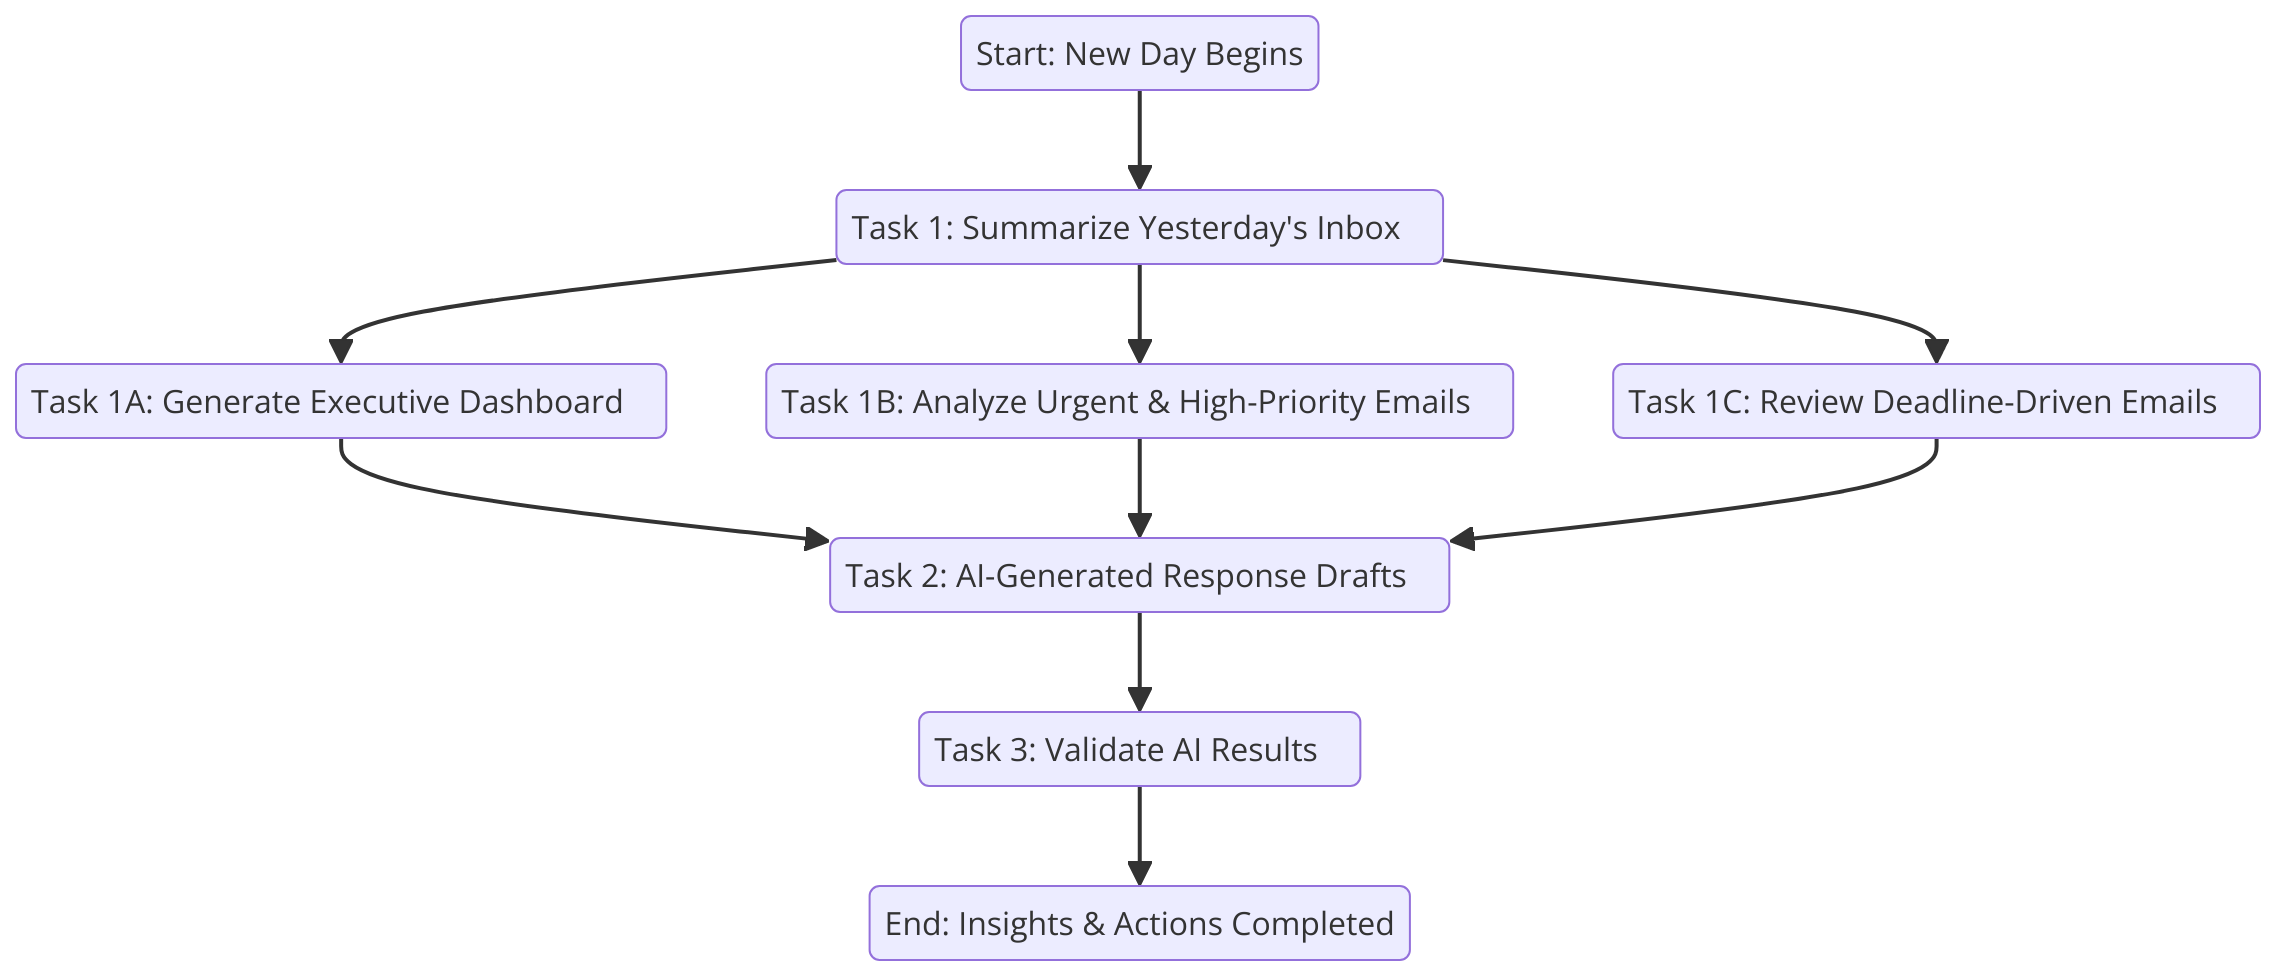

### **Objective**

The goal of this project is to create a Generative AI-powered system that:
1. **Summarize** yesterday’s emails into actionable insights. [Yesterbox Approach]
2. **Prioritizes** emails based on urgency, sender, and context.
3. **Drafts** context-aware responses, reducing manual effort.



# Setup and configuration

This section installs dependencies, configures your OpenAI client, and prepares the helper functions the rest of the notebook uses.


In [1]:
!pip install -q openai==1.61.1 gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 12.0 MB/s eta 0:00:00


### API key setup

To keep this notebook portable and safe for GitHub, you paste your own OpenAI API key at runtime instead of storing it in a file.


**How this works**

- The next cell uses `getpass` so the key is never printed in the notebook.
- The key is stored in the `OPENAI_API_KEY` environment variable for the `openai` client.
- When someone forks or downloads this repo, they can use their own key without touching the rest of the code.


In [2]:
# Universal API key loader:
# 1. Checks Google Colab secrets (userdata)
# 2. Checks environment variables (GitHub Codespaces, local dev, CI/CD)
# 3. Falls back to a secure user prompt
#
# This demonstrates full secret-management capability across:
# - Colab
# - GitHub Codespaces
# - VSCode / local dev
# - Jupyter
# - CI/CD pipelines

import os
from getpass import getpass

colab_key = None

# --- 1. Try Google Colab Secrets ---
try:
    from google.colab import userdata
    colab_key = userdata.get("OPENAI_API_KEY")
    if colab_key:
        os.environ["OPENAI_API_KEY"] = colab_key
        print("✔ OpenAI API key loaded from Google Colab secrets.")
except Exception:
    pass  # Not running in Google Colab


# --- 2. Try environment variable ---
env_key = os.getenv("OPENAI_API_KEY")

if env_key:
    print("✔ OpenAI API key detected in environment. Using existing secret.")

# --- 3. Prompt the user if no key was found in either place ---
if not env_key and not colab_key:
    print("No API key found in Colab secrets or environment.")
    pasted_key = getpass("Enter your OpenAI API key: ")
    os.environ["OPENAI_API_KEY"] = pasted_key
    print("✔ API key loaded into environment for this session.")

print("Ready to initialize the OpenAI client.")


✔ OpenAI API key loaded from Google Colab secrets.
✔ OpenAI API key detected in environment. Using existing secret.
Ready to initialize the OpenAI client.


In [3]:
model_name = "gpt-4o-mini"

- The API key and base URL are stored in environment variables to avoid hardcoding sensitive information in the code.
- The `OpenAI()` object helps us interact with the model for prompt generation.


In [4]:
from openai import OpenAI

# Initialize OpenAI client
client = OpenAI()

- This function helps **interact with the AI model** using two prompts:
  - **System Prompt:** Provides **background instructions** to the model on how to behave.
  - **User Prompt:** Contains the **user's query or task**.
- The `client.chat.completions.create()` method sends the request to the GPT model.
- The *temperature=0* setting ensures the response is **deterministic and consistent**.
- If any error occurs, the function will **print the error message**.


In [5]:
# @title LLM function
# @markdown Once the API details are filled, the notebook will automatically load the configuration, and learners can generate model outputs using the llm() function.


def llm(system_prompt, user_prompt):
  try:
      # Craft the messages to pass to chat.completions.create
      prompt = [
          {'role':'system', 'content': system_prompt},
          {'role': 'user', 'content': user_prompt}
      ]

      response = client.chat.completions.create(
          model=model_name,
          messages=prompt,
          temperature=0
      )

      return response.choices[0].message.content.strip()

  except Exception as e:
      prediction = f'Sorry, I encountered the following error: \n {e}'
      print(prediction)

# **Data Setup**


### **Background**

**Name**: Alex Carter  
**Company**: Orion Tech Solutions (A mid-sized IT services company)  
**Role**: Senior Manager, Software Developement  

#### **About You**  
Alex oversees multiple projects related to software development and IT infrastructure. Your role involves coordinating with stakeholders, ensuring timely delivery, handling escalations, and approving critical project-related decisions. You work with internal teams, vendors, and clients, making communication a crucial part of your job.


**Objective:** Load the dataset containing email records and apply the Yesterbox approach to filter emails received on the previous day.

In [6]:
# If the file is not in the notebook folder look below for the upload the file option
# @title Data source (local-first, CSV+Excel, upload if missing, date-smart, robust encoding)
# ✅ This will work with the TEST file: Alex_emails_march_04.csv
# ✅ Also works with: Alex_emails_march_04_data.csv
# ✅ And future daily files like: Alex_emails_march_05.xlsx, Alex_emails_march_06.xlsx
#
# What this cell does (no Google Drive at all):
# 1) Looks ONLY in the notebook’s current folder for files named Alex_emails_<month>_<day>*.csv/.xlsx/.xls
#    - Prefers a file that contains "cleaned" in its name (e.g., Alex_emails_march_04_cleaned.csv).
#    - Otherwise uses the most recent original (e.g., Alex_emails_march_04.csv).
# 2) If nothing is found locally, it prompts you to upload a file from your computer.
# 3) If an original file is chosen, runs cleaning steps here
# 4) Robust CSV loader: tries utf-8, utf-8-sig, cp1252, latin-1; falls back to delimiter sniffing; reports what it used.
# 5) Optionally saves a side-by-side *_cleaned copy using the SAME extension.
# 6) Prints clear provenance (file path, md5, shape, date inferred from filename).

import os
import re
import io
import csv
import glob
import time
import hashlib
import warnings
import pandas as pd
from datetime import datetime

warnings.filterwarnings("ignore", category=UserWarning)

# --- environment probe (no Google Drive) ---
in_colab = False
try:
    import google.colab  # type: ignore
    in_colab = True
except Exception:
    in_colab = False

# --- search roots: current directory only ---
SEARCH_ROOTS = [os.getcwd()]

# --- patterns (CSV + Excel) ---
PAT_GLOBS = [
    "Alex_emails_*.csv",
    "Alex_emails_*.xlsx",
    "Alex_emails_*.xls",
]
PAT_ANY_CLEANED = re.compile(r"cleaned", re.IGNORECASE)

# --- month parsing for names like Alex_emails_march_04.csv ---
MONTHS = {
    "jan": 1, "january": 1,
    "feb": 2, "february": 2,
    "mar": 3, "march": 3,
    "apr": 4, "april": 4,
    "may": 5,
    "jun": 6, "june": 6,
    "jul": 7, "july": 7,
    "aug": 8, "august": 8,
    "sep": 9, "sept": 9, "september": 9,
    "oct": 10, "october": 10,
    "nov": 11, "november": 11,
    "dec": 12, "december": 12,
}
FN_DATE_REGEX = re.compile(r"Alex_emails_(?P<month>[A-Za-z]+)_(?P<day>\d{1,2})", re.IGNORECASE)

def extract_date_from_filename(path: str):
    """Parse month name and day from filename; return (year, month, day) using current year for ordering."""
    base = os.path.basename(path)
    m = FN_DATE_REGEX.search(base)
    if not m:
        return None
    mon_txt = m.group("month").lower()
    day_txt = m.group("day")
    if mon_txt not in MONTHS:
        return None
    try:
        month = MONTHS[mon_txt]
        day = int(day_txt)
        year = datetime.now().year
        return (year, month, day)
    except Exception:
        return None

def md5sum(path):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(1_048_576), b""):
                h.update(chunk)
        return h.hexdigest()
    except Exception:
        return "unknown"

def glob_all(patterns, roots):
    out = []
    for root in roots:
        if not os.path.isdir(root):
            continue
        for pattern in patterns:
            out.extend(glob.glob(os.path.join(root, pattern), recursive=False))
            out.extend(glob.glob(os.path.join(root, "**", pattern), recursive=True))
    # dedupe, preserve order
    seen = set()
    unique = []
    for p in out:
        if p not in seen:
            unique.append(p)
            seen.add(p)
    return unique

def sorted_by_date_then_mtime(paths):
    """Sort pref: has parseable date, newer date first, newer mtime first."""
    def sort_key(p):
        parsed = extract_date_from_filename(p)
        mtime = os.path.getmtime(p)
        has_date = 1 if parsed is not None else 0
        return (-has_date,
                0 if parsed is None else -(parsed[0]*10000 + parsed[1]*100 + parsed[2]),
                -mtime)
    return sorted(paths, key=sort_key)

# ---------- robust CSV loader ----------
def _sniff_delimiter_from_bytes(sample_bytes: bytes, default=","):
    try:
        # decode best-effort just for sniffing
        text = sample_bytes.decode("utf-8", errors="ignore")
        dialect = csv.Sniffer().sniff(text, delimiters=[",", ";", "\t", "|"])
        return dialect.delimiter
    except Exception:
        return default

def read_csv_robust(path: str) -> pd.DataFrame:
    """
    Load CSV trying multiple encodings and delimiter sniffing.
    Reports encoding and delimiter used via print().
    """
    encodings = ["utf-8", "utf-8-sig", "cp1252", "latin-1"]
    # quick sniff for delimiter
    try:
        with open(path, "rb") as fb:
            sample = fb.read(64_000)
        delim = _sniff_delimiter_from_bytes(sample, default=",")
    except Exception:
        delim = ","

    last_err = None
    for enc in encodings:
        try:
            df_try = pd.read_csv(path, encoding=enc, delimiter=delim, engine="python", low_memory=False)
            print(f"[CSV loader] encoding={enc}, delimiter='{delim}'")
            return df_try
        except UnicodeDecodeError as e:
            last_err = e
            continue
        except Exception as e:
            # try again with default parser if engine=python failed oddly
            try:
                df_try = pd.read_csv(path, encoding=enc, delimiter=delim, low_memory=False)
                print(f"[CSV loader] encoding={enc}, delimiter='{delim}'")
                return df_try
            except Exception as e2:
                last_err = e2
                continue

    # last resort: decode bytes with latin-1 replace and re-parse
    try:
        with open(path, "rb") as fb:
            data = fb.read()
        text = data.decode("latin-1", errors="replace")
        print("[CSV loader] fallback latin-1 decoded with replacement, delimiter='{}'".format(delim))
        return pd.read_csv(io.StringIO(text), delimiter=delim, engine="python", low_memory=False)
    except Exception as e3:
        raise last_err or e3

def load_dataframe(path: str) -> pd.DataFrame:
    """Dispatch to CSV or Excel loader."""
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        return read_csv_robust(path)
    elif ext in (".xlsx", ".xls"):
        return pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {ext}")

def save_cleaned_dataframe(df: pd.DataFrame, base_path: str):
    """Save *_cleaned file next to the source using the SAME extension."""
    base, ext = os.path.splitext(base_path)
    cleaned_out = base + "_cleaned" + ext
    try:
        to_save = df.reset_index(drop=False) if df.index.name == "email_id" else df.copy()
        if ext == ".csv":
            to_save.to_csv(cleaned_out, index=False)
        elif ext in (".xlsx", ".xls"):
            to_save.to_excel(cleaned_out, index=False)
        else:
            raise ValueError(f"Unsupported extension for saving: {ext}")
        print(f"Saved cleaned copy to: {cleaned_out}")
    except Exception as e:
        print(f"Note: could not save cleaned copy: {e}")

# --- discover files in current folder (CSV + Excel) ---
all_files = glob_all(PAT_GLOBS, SEARCH_ROOTS)
cleaned_candidates = [p for p in all_files if PAT_ANY_CLEANED.search(os.path.basename(p))]
original_candidates = [p for p in all_files if not PAT_ANY_CLEANED.search(os.path.basename(p))]
cleaned_candidates = sorted_by_date_then_mtime(cleaned_candidates)
original_candidates = sorted_by_date_then_mtime(original_candidates)

chosen_path = None
chosen_kind = None
chosen_date_from_name = None

if cleaned_candidates:
    chosen_path = cleaned_candidates[0]
    chosen_kind = "cleaned_file"
    chosen_date_from_name = extract_date_from_filename(chosen_path)
elif original_candidates:
    chosen_path = original_candidates[0]
    chosen_kind = "original_file"
    chosen_date_from_name = extract_date_from_filename(chosen_path)

# --- if nothing found, prompt for upload (still no Drive) ---
if not chosen_path:
    print("No 'Alex_emails_*.csv/.xlsx/.xls' found in this folder.")
    print("Please upload the file from your computer.")

    uploaded_path = None

    if in_colab:
        try:
            from google.colab import files  # type: ignore
            uploaded = files.upload()
            if uploaded:
                name = list(uploaded.keys())[0]
                with open(name, "wb") as f:
                    f.write(uploaded[name])
                uploaded_path = os.path.join(os.getcwd(), name)
        except Exception as e:
            print(f"Colab upload not available: {e}")

    if uploaded_path is None:
        try:
            from IPython.display import display
            from ipywidgets import FileUpload, HTML, VBox
            up = FileUpload(accept=".csv,.xlsx,.xls", multiple=False)
            msg = HTML("<b>Upload a file like Alex_emails_march_04.csv or Alex_emails_march_05.xlsx</b>")
            display(VBox([msg, up]))

            timeout_s = 300
            start = time.time()
            while not up.value and (time.time() - start) < timeout_s:
                time.sleep(0.5)

            if up.value:
                info = list(up.value.values())[0]
                name = info["metadata"]["name"]
                content = info["content"]
                with open(name, "wb") as f:
                    f.write(content)
                uploaded_path = os.path.join(os.getcwd(), name)
        except Exception as e:
            print(f"Jupyter widget upload not available: {e}")

    if uploaded_path is None:
        try:
            manual = input("Enter full path to your CSV/Excel file (or press Enter to cancel): ").strip()
            if manual and os.path.isfile(manual):
                uploaded_path = manual
        except Exception:
            pass

    if uploaded_path is None:
        raise FileNotFoundError("No file provided. Place the file next to the notebook or upload it.")

    chosen_path = uploaded_path
    chosen_kind = "cleaned_file" if PAT_ANY_CLEANED.search(os.path.basename(chosen_path)) else "original_file"
    chosen_date_from_name = extract_date_from_filename(chosen_path)

# --- your cleaning steps (edit to your real steps) ---
def apply_my_cleaning(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Replace these placeholders with the exact steps you used when producing your cleaned workbook.

    """
    df = df_raw.copy()

    # Example cleaning:
    if "date_received" in df.columns:
        df["date_received"] = pd.to_datetime(df["date_received"], errors="coerce")

    # Strip whitespace on text columns
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].astype(str).str.strip()

    # Normalize booleans if present
    for c in ["is_urgent", "needs_approval"]:
        if c in df.columns:
            df[c] = df[c].map(
                lambda x: str(x).strip().lower() in {"true", "1", "yes", "y", "t"}
                if pd.notnull(x) else False
            ).astype(bool)

    # Add any renames/drops/fixes you actually used
    # df.rename(columns={"old":"new"}, inplace=True)
    # df.drop(columns=["unused"], errors="ignore", inplace=True)

    return df

# --- load and provenance ---
print("==== Data provenance ====")
print(f"Chosen: {chosen_kind}")
print(f"Path:   {chosen_path}")
print(f"MD5:    {md5sum(chosen_path)}")
if chosen_date_from_name:
    y, m, d = chosen_date_from_name
    print(f"Date inferred from filename: {y}-{m:02d}-{d:02d}")
else:
    print("Date inferred from filename: <not found>")

tmp = load_dataframe(chosen_path)

if chosen_kind == "cleaned_file":
    df = tmp.copy()
    if "email_id" in df.columns:
        df.set_index("email_id", inplace=True, drop=True)
else:
    df = apply_my_cleaning(tmp)

print(f"Loaded shape: {df.shape}")
if "date_received" in df.columns:
    try:
        _dr = pd.to_datetime(df["date_received"], errors="coerce").dt.date
        uniq = sorted(set(_dr.dropna()))
        print(f"Unique dates in dataset (from content): {uniq}")
    except Exception:
        pass
print("=========================")

# --- optional: save a side-by-side *_cleaned copy using the SAME extension ---
SAVE_CLEANED_COPY = True
if SAVE_CLEANED_COPY and chosen_kind == "original_file":
    save_cleaned_dataframe(df, chosen_path)




==== Data provenance ====
Chosen: original_file
Path:   /content/Alex_emails_march_04.csv
MD5:    cb3a6a57e4ce1ab7865e980c5f44a2dc
Date inferred from filename: 2025-03-04
[CSV loader] encoding=cp1252, delimiter=','
Loaded shape: (60, 6)
Unique dates in dataset (from content): [datetime.date(2025, 2, 26), datetime.date(2025, 3, 3), datetime.date(2025, 3, 4)]
Saved cleaned copy to: /content/Alex_emails_march_04_cleaned.csv


# I want this to be usable in the future

In [7]:
# @title Step 2: Apply Yesterbox Filtering
# @markdown The Yesterbox approach processes emails from the previous day first.
# @markdown This version is future-proof: it infers "today" from the file name
# @markdown (e.g., Alex_emails_march_04.csv/.xlsx), then computes "yesterday"
# @markdown and filters the dataset to that date. If parsing the file name fails,
# @markdown it falls back to the max date in the data as "today".

import re
from datetime import datetime, timedelta
import calendar

# -----------------------------
# 1) Helper: get "today" from file name like "Alex_emails_march_04..."
#    Assumptions: Alex exports last 24 hours each morning
#    and names the file "Alex_emails_<monthname>_<day>".
#    Example: Alex_emails_march_04.csv  -> today = Mar 4 of current year
# -----------------------------

def _parse_today_from_filename(pathlike) -> datetime | None:
    """
    Try to extract a month name and day from the chosen file name.
    Returns a datetime.date at local current year if successful, else None.
    Accepted patterns (case-insensitive):
      Alex_emails_march_04.csv
      Alex_emails_March_4_data.xlsx
      Alex_emails_march_04_cleaned.csv
    """
    if pathlike is None:
        return None

    fname = str(pathlike)
    m = re.search(r'Alex[_\- ]emails[_\- ]([A-Za-z]+)[_\- ](\d{1,2})', fname, flags=re.IGNORECASE)
    if not m:
        return None

    month_name = m.group(1).lower()
    day_str = m.group(2)

    # Map month name -> month number (robust to abbreviations like "sept", "sep", etc.)
    month_map = {mname.lower(): idx for idx, mname in enumerate(calendar.month_name) if mname}
    # Add common abbreviations
    month_map.update({
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'sept': 9, 'oct': 10, 'nov': 11, 'dec': 12
    })

    if month_name not in month_map:
        return None

    month_num = month_map[month_name]
    day_num = int(day_str)

    # Use the current year so this continues to work in the future
    this_year = datetime.now().year

    try:
        return datetime(this_year, month_num, day_num)
    except ValueError:
        # If the date is invalid, give up on filename parsing
        return None


# -----------------------------
# 2) Determine "today" for this run
#    Priority: chosen_path from Step 1 -> parse from file name
#    Fallback: use max(df["date_received"]) as "today"
# -----------------------------
_today_dt = None

# If Step 1 defined chosen_path, use it. Otherwise this stays None.
try:
    _today_dt = _parse_today_from_filename(chosen_path)
except NameError:
    # chosen_path may not exist if Step 1 was changed; ignore and fallback
    _today_dt = None

if _today_dt is None:
    # Fallback: infer "today" from the data (max date in df)
    # This is robust if the file name pattern changes but the content is correct.
    _dr = pd.to_datetime(df["date_received"], errors="coerce")
    max_date = _dr.max()
    if pd.isna(max_date):
        raise ValueError("Could not infer 'today' from file name or data. Check date_received values.")
    # Treat max date as "today"
    _today_dt = pd.to_datetime(max_date).normalize()

# Compute "yesterday" based on inferred "today"
_yesterday_dt = (_today_dt - timedelta(days=1)).date()

# -----------------------------
# 3) Normalize df["date_received"] to date and filter for Yesterbox
# -----------------------------
# Create a normalized date column (date only) without changing original column
_df_dates = pd.to_datetime(df["date_received"], errors="coerce").dt.date

# Filter rows where the date is exactly "yesterday"
yesterday_emails = df.loc[_df_dates == _yesterday_dt].reset_index(drop=True)

print("========== Yesterbox Filter ==========")
print(f"File-based today:        {_today_dt.date()}")
print(f"Computed yesterday:      {_yesterday_dt}")
print(f"Filtered Emails Count:   {len(yesterday_emails)}")

try:
    display(yesterday_emails.head(3))
except Exception:
    pass
print("======================================")


========== Yesterbox Filter ==========
File-based today:        2025-03-04
Computed yesterday:      2025-03-03
Filtered Emails Count:   51


,email_id,date_received,sender,subject,body,main_recipient
0,1,2025-03-03,Julia Martin,Approval Request: Budget Approval Needed by EOD,"Hi Alex,\n\nI hope you're doing well. As we ap...",Alex
1,2,2025-03-03,Fiona White,Are Your APIs Secure? Reddit & Discord Sound t...,"Hi Alex,\n\nA heated Discord discussion in the...",Alex
2,3,2025-03-03,Samantha Lee,Approval Needed: Project Scope Adjustment for ...,"Hi Alex,\n\nWe’ve encountered an unexpected AP...",Alex


In [8]:
df.shape

(60, 6)

In [9]:
# Here we see only 51 emails, as in 10 email had the date of 4th March 2025
yesterday_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   email_id        51 non-null     int64         
 1   date_received   51 non-null     datetime64[ns]
 2   sender          51 non-null     object        
 3   subject         51 non-null     object        
 4   body            51 non-null     object        
 5   main_recipient  51 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.5+ KB


In [10]:
# @title Code to add categories to the dataset
categories = ['Urgent & High-Priority Emails',
              'Deadline-Driven Emails',
              'Routine Updates & Check-ins',
              'Non-Urgent Informational Emails',
              'Personal & Social Emails',
              'Spam/Unimportant Emails']

In [11]:
# @title Define system_prompt
# AI Identity & Role Definition: AI’s function is to be an email assistant.
# WHY THIS CELL: This defines the rules the model must follow when labeling emails.



system_prompt = """
You are an email triage assistant for Alex. Classify ONE email into EXACTLY ONE of these categories:

1) Urgent & High-Priority Emails
   Definition: Requires immediate action and must be addressed today.
   Strong signals include:
     - Explicit urgency: "urgent", "ASAP", "immediately", "EOD/COB", "high priority", "P1", "sev 1".
     - Production incidents/outages: service down, blocking issue, major customer impact, war room invites.
     - Due today or tomorrow (e.g., “due EOD”, “by tomorrow morning”).
   Examples:
     - "[URGENT] Dashboard Syncing Issues – Production Metrics Missing"
     - "Blocking Issue Alert – Client Data Sync Failing"
     - "Approval Request: Budget Approval Needed by EOD"

2) Deadline-Driven Emails
   Definition: Time-sensitive or scheduling items that need attention today or tomorrow but are NOT an outage/incident.
   Signals:
     - Near-term date/time: “today”, “tomorrow”, “by March 6, 2025”, “this afternoon”, “next week” with a required response/action.
     - Meeting requests needing a response/acceptance within a day.
   Examples:
     - "Deadline: Submit Q1 Forecast by March 6, 2025"
     - "Please confirm attendance for tomorrow’s design review"

3) Routine Updates & Check-ins
   Definition: Needs review/acknowledgment; no immediate action or deadline.
   Signals:
     - Daily/weekly status updates, standups, progress notes, summaries.
   Example:
     - "Daily Update – Project Titan (March 3)"

4) Non-Urgent Informational Emails
   Definition: FYIs that can be deferred or delegated; no near-term action required.
   Signals:
     - Industry news, long-form articles, announcements without deadlines.
   Example:
     - "Are Your APIs Secure? Reddit & Discord Sound the Alarm"

5) Personal & Social Emails
   Definition: Personal/social notes not tied to work deliverables.
   Examples:
     - "Hey Alex, how are you?"
     - "Do you want to go to happy hour?"

6) Spam/Unimportant Emails
   Definition: Irrelevant ads/promos/scams/phishing/low-value mass marketing.
   Examples:
     - "Alex, This Rolex Would Look GREAT on Your Wrist ?"
     - "You Won a Free iPhone 15 Pro! ?? Click to Claim"

TIE-BREAKERS (apply in this exact priority order if multiple seem to fit):
   Urgent & High-Priority Emails  >  Deadline-Driven Emails  >  Routine Updates & Check-ins
   >  Non-Urgent Informational Emails  >  Personal & Social Emails  >  Spam/Unimportant Emails

ADDITIONAL RULES:
- Consider BOTH subject and body; ignore signatures/footers/legal/unsubscribe blocks if they conflict.
- If multiple categories appear plausible, choose the HIGHEST applicable per the tie-breaker order.
- OUTPUT REQUIREMENT: Return ONLY the exact category name from the allowed list—no quotes, punctuation, or extra text.

ALLOWED OUTPUT STRINGS (MUST MATCH EXACTLY):
Urgent & High-Priority Emails
Deadline-Driven Emails
Routine Updates & Check-ins
Non-Urgent Informational Emails
Personal & Social Emails
Spam/Unimportant Emails
"""


In [12]:
# @title Define user_prompt builder
# AI Identity & Role Definition: AI’s function is to be an email assistant.
# WHY THIS CELL:
# A static user_prompt string is too vague. This function builds the prompt
# dynamically from each email’s metadata and body so the model has the right context.

def build_user_prompt(email_date, sender, subject, body):
    """
    Build the user_prompt for a single email.
    Keep it tight and explicit so the model returns exactly one
    of the allowed category strings.
    """
    return f"""
Classify the following email into EXACTLY ONE of the allowed categories.
Return ONLY the category name, nothing else.

Allowed categories:
- Urgent & High-Priority Emails
- Deadline-Driven Emails
- Routine Updates & Check-ins
- Non-Urgent Informational Emails
- Personal & Social Emails
- Spam/Unimportant Emails

Email metadata:
- Date: {email_date}
- From: {sender}
- Subject: {subject}

Email body:
\"\"\"
{body}
\"\"\"
"""


In [13]:
## @title Classify emails, verify every row has a category, and display Subject + Category (with progress bar, robust loader, frozen snapshot)
# AI Identity & Role Definition: AI’s function is to be an email assistant.
# WHAT THIS DOES
# 1) Loads emails safely (prefer existing DataFrame; otherwise glob for a CSV in /mnt/data).
# 2) Builds a per-email user_prompt with the actual subject/body.
# 3) Calls `llm(system_prompt, user_prompt)` to get a single label.
# 4) Normalizes the model output to one of the six allowed labels (exact mapping).
# 5) Writes the label to df['category'].
# 6) TEST: verifies every row received a valid category.
# 7) DISPLAY: prints a clean table with Subject + Category.
# 8) FREEZE: saves a snapshot `classified_emails` so later cells cannot overwrite your labels.

import os, glob
import pandas as pd
from tqdm import tqdm
from IPython.display import display

# ----------------------------
# Allowed labels (strict check)
# ----------------------------
ALLOWED_LABELS = [
    "Urgent & High-Priority Emails",
    "Deadline-Driven Emails",
    "Routine Updates & Check-ins",
    "Non-Urgent Informational Emails",
    "Personal & Social Emails",
    "Spam/Unimportant Emails",
]
# exact, safe mapping for normalization (no substring tricks)
NORMALIZE_MAP = {
    "urgent & high-priority emails": "Urgent & High-Priority Emails",
    "deadline-driven emails": "Deadline-Driven Emails",
    "routine updates & check-ins": "Routine Updates & Check-ins",
    "non-urgent informational emails": "Non-Urgent Informational Emails",
    "personal & social emails": "Personal & Social Emails",
    "spam/unimportant emails": "Spam/Unimportant Emails",
}

def _normalize_label(s):
    """Map model output to one of the six exact strings; return None if not exact."""
    if not isinstance(s, str):
        return None
    t = s.strip().strip('"').strip("'").strip()
    key = t.lower().replace("–", "-").replace("—", "-")
    return NORMALIZE_MAP.get(key, None)

def _get_col(row, name, fallbacks):
    """Tolerate different column names across datasets."""
    cmap = {c.lower(): c for c in row.index}
    if name.lower() in cmap:
        return row[cmap[name.lower()]]
    for fb in fallbacks:
        if fb.lower() in cmap:
            return row[cmap[fb.lower()]]
    return ""

# ----------------------------
# Robust loader for input data
# ----------------------------
def _load_input_df():
    # Prefer an existing DataFrame named `yesterday_emails`
    if "yesterday_emails" in globals() and isinstance(yesterday_emails, pd.DataFrame):
        print("Loaded input from existing DataFrame `yesterday_emails`.")
        return yesterday_emails.copy(), "existing DataFrame `yesterday_emails`"

    # Otherwise, discover a CSV under /mnt/data
    candidates = [
        "/mnt/data/Alex_emails_march_04_cleaned (1).csv",
        "/mnt/data/Alex_emails_march_04_cleaned.csv",
        "/mnt/data/Alex_emails_march_04.csv",
    ]
    # add any file that looks close
    candidates += sorted(
        glob.glob("/mnt/data/*Alex*emails*mar*04*.*csv*"),
        key=lambda p: os.path.getmtime(p),
        reverse=True,
    )
    for path in candidates:
        if os.path.exists(path):
            print(f"Loaded input from CSV: {path}")
            return pd.read_csv(path), f"CSV file: {path}"

    raise FileNotFoundError(
        "Could not find an emails CSV in /mnt/data. "
        "Upload your file (e.g., Alex_emails_march_04_cleaned.csv) and re-run."
    )

# 1) Load emails
df, source = _load_input_df()


if len(df) > 51:
    df = df.head(51)

# Prepare output column
if "category" not in [c.lower() for c in df.columns]:
    df["category"] = None

# 2–5) Loop and classify each email with a progress bar
for i, row in tqdm(df.iterrows(), total=len(df), desc="Classifying emails"):
    email_date = _get_col(row, "date", ["received_date", "email_date", "timestamp"])
    sender     = _get_col(row, "from", ["sender", "sender_name", "from_address", "email_from"])
    subject    = _get_col(row, "subject", ["email_subject", "title"])
    body       = _get_col(row, "body", ["text", "content", "email_body", "message"])

    user_prompt = build_user_prompt(email_date, sender, subject, body)

    raw = llm(system_prompt, user_prompt)
    label = _normalize_label(raw)

    # Nudge once if the first answer wasn’t a valid exact label
    if label is None:
        raw = llm(system_prompt, user_prompt + "\nReturn exactly one of the allowed category names above, verbatim.")
        label = _normalize_label(raw)

    # Final fallback: assign the lowest-priority label rather than leave it empty
    if label is None:
        label = "Spam/Unimportant Emails"

    df.at[i, "subject"] = subject  # ensure a subject column exists for display
    df.at[i, "category"] = label

# 6) TEST: verify every row has a valid label
missing = df["category"].isna().sum() + (df["category"] == "").sum()
invalid = (~df["category"].str.lower().isin(list(NORMALIZE_MAP.keys()))).sum()
if missing == 0 and invalid == 0:
    print("TEST PASS: Every email has a valid category from the allowed list.")
else:
    print(f"TEST FAIL: {missing} missing and {invalid} invalid labels detected.")

print(f"Showing {len(df)} rows from {source}.")

# Update the canonical name BEFORE display so later cells can use it
yesterday_emails = df

# 7) DISPLAY: Subject + Category table
cols = ["subject", "category"]
avail = [c for c in cols if c in df.columns]
df_view = df[avail].copy()
df_view = df_view.rename(columns={"subject": "Subject", "category": "Category"})
df_view.reset_index(drop=True, inplace=True)
display(df_view)

# 8) Freeze a snapshot of the labeled data for downstream summary
classified_emails = yesterday_emails.copy()


Loaded input from existing DataFrame `yesterday_emails`.


Classifying emails: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]

TEST PASS: Every email has a valid category from the allowed list.
Showing 51 rows from existing DataFrame `yesterday_emails`.


,Subject,Category
0,Approval Request: Budget Approval Needed by EOD,Urgent & High-Priority Emails
1,Are Your APIs Secure? Reddit & Discord Sound t...,Non-Urgent Informational Emails
2,Approval Needed: Project Scope Adjustment for ...,Deadline-Driven Emails
3,Subject: Daily Update – Project Titan (March 3),Routine Updates & Check-ins
4,[URGENT] Dashboard Syncing Issues – Production...,Urgent & High-Priority Emails
5,Quick Check-In – Frontend Updates,Routine Updates & Check-ins
6,Approval Request: Additional AWS Resources for...,Deadline-Driven Emails
7,Blocking Issue Alert – Client Data Sync Failing,Urgent & High-Priority Emails
8,Daily Update – API Migration (March 3),Routine Updates & Check-ins
9,URGENT: Approval Needed for 2-Week Extension o...,Urgent & High-Priority Emails


In [14]:
# @title Categorizing the emails (SAFE — display only; no overwrite)
# This cell used to RE-RUN classification and overwrite good labels.
# Now it just verifies that labels exist and displays them. No changes are made.

from IPython.display import display
import pandas as pd

CAT_COL = "category" if "category" in yesterday_emails.columns else "Category" if "Category" in yesterday_emails.columns else None
if CAT_COL is None:
    raise ValueError("No 'category' column found. Run the main classification cell first.")

# If the column already has labels, DO NOT touch it.
has_labels = yesterday_emails[CAT_COL].astype(str).str.len().gt(0).any()
if has_labels:
    print("Labels already present in 'category'. Skipping reclassification to avoid overwriting.")
else:
    print("No labels detected. (If you truly need to re-run classification, do it in the main classification cell.)")

# Show a compact view
cols = [c for c in ["subject", CAT_COL] if c in yesterday_emails.columns]
df_view = yesterday_emails[cols].copy()
df_view = df_view.rename(columns={"subject": "Subject", CAT_COL: "Category"})
df_view.reset_index(drop=True, inplace=True)
display(df_view.head(10))
print(f"(Showing first 10 of {len(df_view)} rows. Full table is in the previous classification cell.)")


Labels already present in 'category'. Skipping reclassification to avoid overwriting.


,Subject,Category
0,Approval Request: Budget Approval Needed by EOD,Urgent & High-Priority Emails
1,Are Your APIs Secure? Reddit & Discord Sound t...,Non-Urgent Informational Emails
2,Approval Needed: Project Scope Adjustment for ...,Deadline-Driven Emails
3,Subject: Daily Update – Project Titan (March 3),Routine Updates & Check-ins
4,[URGENT] Dashboard Syncing Issues – Production...,Urgent & High-Priority Emails
5,Quick Check-In – Frontend Updates,Routine Updates & Check-ins
6,Approval Request: Additional AWS Resources for...,Deadline-Driven Emails
7,Blocking Issue Alert – Client Data Sync Failing,Urgent & High-Priority Emails
8,Daily Update – API Migration (March 3),Routine Updates & Check-ins
9,URGENT: Approval Needed for 2-Week Extension o...,Urgent & High-Priority Emails


(Showing first 10 of 51 rows. Full table is in the previous classification cell.)


In [15]:
# Display the DataFrame which has categories
yesterday_emails.head()

,email_id,date_received,sender,subject,body,main_recipient,category
0,1,2025-03-03,Julia Martin,Approval Request: Budget Approval Needed by EOD,"Hi Alex,\n\nI hope you're doing well. As we ap...",Alex,Urgent & High-Priority Emails
1,2,2025-03-03,Fiona White,Are Your APIs Secure? Reddit & Discord Sound t...,"Hi Alex,\n\nA heated Discord discussion in the...",Alex,Non-Urgent Informational Emails
2,3,2025-03-03,Samantha Lee,Approval Needed: Project Scope Adjustment for ...,"Hi Alex,\n\nWe’ve encountered an unexpected AP...",Alex,Deadline-Driven Emails
3,4,2025-03-03,James Patel,Subject: Daily Update – Project Titan (March 3),"Hey Alex,\n\nQuick update on Project Titan for...",Alex,Routine Updates & Check-ins
4,5,2025-03-03,David Whitmore,[URGENT] Dashboard Syncing Issues – Production...,"Hey Alex,\n\nWe’ve got a big issue right now—l...",Alex,Urgent & High-Priority Emails


# **Awareness of your email: Get to know the detailed summary of your email received**


## **1A. Executive Dashboard (Top-Level Summary of Yesterday’s Inbox)**



Alex’s inbox is a **delicate balance of urgent action items, strategic decisions, and routine updates**. He must **prioritize effectively**—focusing on high-impact emails first, ensuring compliance with deadlines, and delegating less critical tasks to his team.

In this step, you will generate a high-level summary of the emails received using the AI Email Secretary. The AI will categorize emails into distinct categories and generate actionable insights.

In [16]:
# @title Define user_prompt template

def build_user_prompt(email_date, sender_name, sender_address, subject, body):
    return f"""
Classify the following email into exactly one category from the fixed list.
Consider dates like 'today', 'tomorrow', 'EOD/COB', and any incident/production impact.
Return only the category label, nothing else.

Fixed categories:
- Urgent & High-Priority Emails
- Deadline-Driven Emails
- Routine Updates & Check-ins
- Non-Urgent Informational Emails
- Personal & Social Emails
- Spam/Unimportant Emails

Email metadata:
- Date received: {email_date}
- From: {sender_name} <{sender_address}>
- Subject: {subject}

Email body:
\"\"\"
{body}
\"\"\"

Return just one label from the list above.
"""


In [17]:
# @title Executive summary prompts (system + user)
# AI Identity & Role Definition: AI’s function is to be an email assistant.
# WHY: These prompts are for the EXECUTIVE SUMMARY, not classification.
# The model must NOT invent counts. It must only use the counts we pass in.

summary_system_prompt = """
You are an executive assistant. You will receive structured counts of emails by category
and totals already computed by code. Do NOT invent numbers. Use ONLY the provided counts.

Write a concise executive summary for a busy manager. Be direct and plain-English.
Call out "Critical Emails Requiring Immediate Attention" as the sum of:
- Urgent & High-Priority Emails
- Deadline-Driven Emails

Then separate the remainder as "Emails That Can Be Reviewed Later."
Keep it short and skimmable. No fluff.
"""

def build_summary_user_prompt(counts_json_str):
    """
    Build the user prompt for the summary step.
    We pass the counts as JSON so the model can't misread a table.
    """
    return f"""
You are given pre-computed counts as JSON. Use ONLY these numbers.

COUNTS_JSON:
{counts_json_str}

Write:
1) Total Number of Emails Received
2) Total Number of Emails from Yesterday
3) Email Breakdown by Categories (Count Only)
4) AI Conclusion:
   - Critical Emails Requiring Immediate Attention:
     * Urgent & High-Priority
     * Deadline-Driven
     * Total Critical Emails
   - Emails That Can Be Reviewed Later:
     * Total Non-Critical Emails

Keep it tight and factual. Do not invent or change any counts.
"""


In [18]:
# @title Executive Summary (exact template to match sample)
# AI Identity & Role Definition: AI’s function is to be an email assistant.
# PURPOSE
# - Read the already-labeled DataFrame (prefers `classified_emails`, falls back to `yesterday_emails`).
# - Compute category counts deterministically (no normalization, no LLM counting).
# - Render a Markdown summary that matches the sample exactly, including bullets and a short insight paragraph.
# - Also show a verification table under the prose.

import pandas as pd
from IPython.display import Markdown, display
import datetime as dt

# 0) Pick the labeled DataFrame (frozen snapshot if available)
if 'classified_emails' in globals() and isinstance(classified_emails, pd.DataFrame):
    df = classified_emails.copy()
else:
    df = yesterday_emails.copy()

# 1) Which column holds labels?
CAT_COL = 'category' if 'category' in df.columns else ('Category' if 'Category' in df.columns else None)
if CAT_COL is None:
    raise ValueError("No 'category' (or 'Category') column found. Run the classification cell first.")

# 2) Allowed labels (exact match only) and counts
ALLOWED = [
    "Urgent & High-Priority Emails",
    "Deadline-Driven Emails",
    "Routine Updates & Check-ins",
    "Non-Urgent Informational Emails",
    "Personal & Social Emails",
    "Spam/Unimportant Emails",
]
counts = {label: int((df[CAT_COL] == label).sum()) for label in ALLOWED}

total = int(len(df))
urgent = counts["Urgent & High-Priority Emails"]
deadline = counts["Deadline-Driven Emails"]
routine = counts["Routine Updates & Check-ins"]
inform  = counts["Non-Urgent Informational Emails"]
personal = counts["Personal & Social Emails"]
spam = counts["Spam/Unimportant Emails"]

critical_total = urgent + deadline
non_critical_total = routine + inform + personal + spam

# 3) “Yesterday” line: try to compute count-from-yesterday if a date column exists
def _first_present(cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

date_col = _first_present(["date","Date","email_date","received_date","timestamp"])
yesterday_count = None
yesterday_note = ""

if date_col:
    s = pd.to_datetime(df[date_col], errors="coerce")
    s_dates = s.dt.tz_localize(None).dt.date if hasattr(s.dt, "tz_localize") else s.dt.date
    yesterday = (pd.Timestamp.now().normalize() - pd.Timedelta(days=1)).date()
    yesterday_count = int((s_dates == yesterday).sum())

    # If nothing is from “yesterday” and all rows share one date, add the note like the sample.
    non_na = s_dates.dropna()
    if yesterday_count == 0 and non_na.nunique() == 1:
        only_date = non_na.iloc[0]
        # Use a month-name format like the screenshot (e.g., March 3, 2025)
        yesterday_note = f" (All emails are dated {pd.to_datetime(only_date).strftime('%B %-d, %Y')})"
else:
    # No date available: mirror total (or set to 0 if you prefer)
    yesterday_count = total

# 4) Render Markdown to match the sample format exactly
md = f"""
# Executive Summary of Emails

1. **Total Number of Emails Received:** {total}
2. **Total Number of Emails from Yesterday:** {yesterday_count}{yesterday_note}
3. **Email Breakdown by Categories (Count Only):**
   - Urgent & High-Priority Emails: {urgent}
   - Deadline-Driven Emails: {deadline}
   - Routine Updates (Review & Acknowledge): {routine}
   - Non-Urgent Informational Emails: {inform}
   - Personal & Social Emails: {personal}
   - Spam/Unimportant Emails: {spam}
4. **AI Conclusion:**
   - **Critical Emails Requiring Immediate Attention:**
     - Urgent & High-Priority: {urgent}
     - Deadline-Driven: {deadline}
     - **Total Critical Emails:** {critical_total}
   - **Emails That Can Be Reviewed Later:**
     - Routine Updates: {routine}
     - Non-Urgent Informational Emails: {inform}
     - Personal & Social Emails: {personal}
     - Spam/Unimportant Emails: {spam}
     - **Total Non-Critical Emails:** {non_critical_total}

**Summary Insights:** The inbox contains a significant number of critical emails ({critical_total}), which require immediate attention, including urgent requests and deadlines that are approaching. This indicates a high workload and the need to prioritize responses to pressing issues. In contrast, there are {non_critical_total} emails that can be reviewed later, allowing for batching and delegation. Address the urgent and deadline-driven items first to mitigate risk and keep deliverables on track.
"""

display(Markdown(md))

# 5) Verification table (cross-check numbers)
counts_table = pd.DataFrame(
    {
        "Category": ALLOWED + ["Total Critical", "Total Non-Critical", "Total"],
        "Count": [urgent, deadline, routine, inform, personal, spam, critical_total, non_critical_total, total],
    }
)
display(counts_table)



# Executive Summary of Emails

1. **Total Number of Emails Received:** 51
2. **Total Number of Emails from Yesterday:** 51
3. **Email Breakdown by Categories (Count Only):**
   - Urgent & High-Priority Emails: 17
   - Deadline-Driven Emails: 11
   - Routine Updates (Review & Acknowledge): 14
   - Non-Urgent Informational Emails: 3
   - Personal & Social Emails: 0
   - Spam/Unimportant Emails: 6
4. **AI Conclusion:**
   - **Critical Emails Requiring Immediate Attention:**
     - Urgent & High-Priority: 17
     - Deadline-Driven: 11
     - **Total Critical Emails:** 28
   - **Emails That Can Be Reviewed Later:**
     - Routine Updates: 14
     - Non-Urgent Informational Emails: 3
     - Personal & Social Emails: 0
     - Spam/Unimportant Emails: 6
     - **Total Non-Critical Emails:** 23

**Summary Insights:** The inbox contains a significant number of critical emails (28), which require immediate attention, including urgent requests and deadlines that are approaching. This indicates a high workload and the need to prioritize responses to pressing issues. In contrast, there are 23 emails that can be reviewed later, allowing for batching and delegation. Address the urgent and deadline-driven items first to mitigate risk and keep deliverables on track.


,Category,Count
0,Urgent & High-Priority Emails,17
1,Deadline-Driven Emails,11
2,Routine Updates & Check-ins,14
3,Non-Urgent Informational Emails,3
4,Personal & Social Emails,0
5,Spam/Unimportant Emails,6
6,Total Critical,28
7,Total Non-Critical,23
8,Total,51


In [19]:
system_prompt = """
You are an AI Email Assistant.

OBJECTIVE
Format the already-filtered set of yesterday’s **Urgent & High-Priority** emails into a clean Markdown report that matches the sample exactly. Do not change any categories. Do not invent content.

PRESENTATION-ONLY PRIORITIZATION (no reclassification)
- You may reorder **for presentation only** so that “urgent” emails from executive senders (VIPs) appear first, followed by all remaining urgent items.
- Keep the original relative order **within each group**.
- VIP detection is **BODY-ONLY** (case-insensitive) by looking for any of these title keywords: "VP", "Vice President", "SVP", "EVP", "Chief", "CEO", "COO", "CFO", "CIO", "CTO", "CMO".
- Also treat as VIP if the sender’s name appears in the VIP_NAMES list passed in the user prompt.
- If ties occur, keep original order inside the affected group.

YESTERBOX RULE
All items were received yesterday and are part of today’s to-do list. If TODAY_DATE and YESTERDAY_DATE are provided, use those. Otherwise infer the common Received date from the rows and format as MM/DD/YYYY.

STRICT OUTPUT FORMAT (must match sample)
- Print this **intro line** verbatim (plain text) before the list:
  Here are the Urgent & High-Priority emails that require your attention or intervention, as per the provided records. All emails listed were received yesterday and are part of today’s to-do list.
- Then print this **bold** section header exactly:
  **Urgent & High-Priority Emails**
- Then output a **numbered list starting at 1**. Each item must have exactly five labeled lines, each on its own line, with the label in **bold** followed by a colon:
  **Subject:** <subject text>
  **Received:** <MM/DD/YYYY>
  **Sender:** <name>
  **Summary:** <1–2 sentence, factual, email-specific summary>
  **Next Step:** <1–2 sentence, concrete action specific to that email>
- Separate items with a single blank line. No extra bullets, tables, underscores, or extra commentary.
- Labels must be bold, each ending with a colon, exactly as shown.
- The list must contain **exactly the same number of rows** as provided (no drops, no additions).

QUALITY BAR
- Be precise and neutral; pull details only from the provided subject/body/sender text.
- Do not reclassify. Do not reorder except as allowed by the presentation-only VIP rule above.
"""




In [20]:
# Filtering out the emails that are urgent and high-priority
urgent_emails = yesterday_emails[yesterday_emails['category'] == 'Urgent & High-Priority Emails']

In [21]:
user_prompt = f"""
Context
- The DataFrame 'urgent_emails' below contains ONLY yesterday’s Urgent & High-Priority emails (total expected: 17).
- The rows reflect the current pipeline’s ordering; you may apply presentation-only VIP bumping as defined in the System Prompt.
- Use TODAY_DATE and YESTERDAY_DATE if present; otherwise infer the single common Received date and render as MM/DD/YYYY.

VIP handling (body-only titles + explicit names)
- Consider these sender names as VIP regardless of title text presence in the body (case-insensitive match on names):
VIP_NAMES = [
  "David Whitmore",
  "Rachel Thompson",
  "Molly Wenzler"
  # Add more names here in the future as needed
]

Your Tasks
1) Without changing categories or fabricating content, produce the Markdown report exactly as specified in the System Prompt.
2) If “urgent” indicators (e.g., urgent, immediate, asap, critical, response needed) appear and a VIP is detected by body-only title keywords or by VIP_NAMES, present those items first; otherwise keep original order.
3) For each row, output the five labeled lines with **bold labels** followed by a colon:
   - **Subject:** use the row’s subject
   - **Received:** use YESTERDAY_DATE if provided; else the row’s received date as MM/DD/YYYY
   - **Sender:** use the row’s sender name
   - **Summary:** 1–2 sentence factual summary grounded in the row’s text
   - **Next Step:** 1–2 sentence concrete action specific to that email
4) Number items starting at 1, with a single blank line between items. Do not add other headings, bullets, or tables.

Variables available (if set upstream):
- TODAY_DATE = {globals().get('today_str', '<<not provided>>')}
- YESTERDAY_DATE = {globals().get('yesterday_str', '<<not provided>>')}

Below is the attached DataFrame to use verbatim (do not alter counts or categories):
{urgent_emails.to_string()}
"""

In [22]:
# Quick peek at the columns in urgent_emails
print(list(urgent_emails.columns))


['email_id', 'date_received', 'sender', 'subject', 'body', 'main_recipient', 'category']


In [23]:
# @title  Calling the model and display the summary
response_2 = llm(system_prompt, user_prompt)

from IPython.display import display, Markdown
display(Markdown(response_2))


Here are the Urgent & High-Priority emails that require your attention or intervention, as per the provided records. All emails listed were received yesterday and are part of today’s to-do list.

**Urgent & High-Priority Emails**

1. **Subject:** [URGENT] Dashboard Syncing Issues – Production Metrics Missing  
   **Received:** 03/03/2025  
   **Sender:** David Whitmore  
   **Summary:** There are significant issues with the Orion Analytics Dashboard where live production metrics are not syncing properly, leading to data gaps. An update is needed within 24 hours to avoid escalation.  
   **Next Step:** Confirm the issue with your team and provide an update on the resolution status.

2. **Subject:** System Crashing During Shift Changes – URGENT  
   **Received:** 03/03/2025  
   **Sender:** David Whitmore  
   **Summary:** The Orion Manufacturing System is crashing during shift changes, preventing operators from logging in and causing operational delays.  
   **Next Step:** Assign someone from your team to investigate the issue and join the scheduled call at 3 PM EST.

3. **Subject:** URGENT: Production Halt – Machine Control System Unresponsive  
   **Received:** 03/03/2025  
   **Sender:** David Whitmore  
   **Summary:** The Orion Machine Control System is unresponsive, halting production and requiring immediate attention.  
   **Next Step:** Call David Whitmore immediately to discuss the situation and provide a status update.

4. **Subject:** URGENT: Critical System Downtime – Immediate Attention Required  
   **Received:** 03/03/2025  
   **Sender:** David Whitmore  
   **Summary:** There is a major outage with the Orion Analytics Dashboard, affecting access to real-time production data and causing operational delays.  
   **Next Step:** Provide an immediate resolution or workaround by 12 PM EST today and update David on the status.

5. **Subject:** URGENT: Medication Alerts Not Firing – This is Dangerous  
   **Received:** 03/03/2025  
   **Sender:** Rachel Thompson  
   **Summary:** Automated medication alerts for ICU patients are not functioning, posing a serious patient safety risk.  
   **Next Step:** Fix the issue immediately and join the emergency call scheduled in 30 minutes.

6. **Subject:** URGENT: Approval for Security Audit Vendor – Time-Sensitive  
   **Received:** 03/03/2025  
   **Sender:** Rachel Lim  
   **Summary:** Approval is needed for the security audit contract with CyberShield, which is time-sensitive due to compliance requirements.  
   **Next Step:** Confirm approval as soon as possible to meet the vendor's deadline.

7. **Subject:** URGENT: Overdue Invoice Approval for Cloud Services  
   **Received:** 03/03/2025  
   **Sender:** Sarah Mitchell  
   **Summary:** An invoice from CloudOps Solutions is overdue, and prompt approval is needed to avoid late fees and service disruption.  
   **Next Step:** Approve the invoice ASAP to prevent penalties.

8. **Subject:** [High Priority] Authentication Failing for Multiple Users  
   **Received:** 03/03/2025  
   **Sender:** Mark Davidson  
   **Summary:** Multiple engineers are unable to log in to the security monitoring platform due to an authentication issue.  
   **Next Step:** Investigate the issue and restore access as soon as possible.

9. **Subject:** Security Patch Caused System Instability?  
   **Received:** 03/03/2025  
   **Sender:** Mark Davidson  
   **Summary:** After a recent security patch, the SOC team has noticed a significant drop in detection accuracy for automated threat detection rules.  
   **Next Step:** Look into the issue to determine if it’s a configuration problem or something deeper.

10. **Subject:** Firewall Logs Disappeared – What’s Going On?  
    **Received:** 03/03/2025  
    **Sender:** Mark Davidson  
    **Summary:** Missing firewall logs from February 20-24 are a major concern for audit compliance.  
    **Next Step:** Check if this is a storage issue or data corruption and provide an update.

11. **Subject:** Approval Request: Budget Approval Needed by EOD  
    **Received:** 03/03/2025  
    **Sender:** Julia Martin  
    **Summary:** Budget approval is needed by the end of the day to ensure smooth execution of next quarter's projects.  
    **Next Step:** Review the attached budget breakdown and provide your approval.

12. **Subject:** Follow-Up: Server Downtime - Critical Fix Required  
    **Received:** 03/03/2025  
    **Sender:** Bob Smith  
    **Summary:** Unexpected server downtime is impacting critical services, and additional input is needed regarding recent configuration changes.  
    **Next Step:** Review the attached logs and provide insights to expedite the fix.

13. **Subject:** Escalation – Valve Healthcare (Zoom)  
    **Received:** 03/03/2025  
    **Sender:** Julia Martin  
    **Summary:** A Zoom meeting is scheduled to discuss ERP system downtime affecting production.  
    **Next Step:** Join the Microsoft Teams meeting at the scheduled time.

14. **Subject:** [URGENT] Dashboard Syncing Issues – Production Metrics Missing  
    **Received:** 03/03/2025  
    **Sender:** David Whitmore  
    **Summary:** There are significant issues with the Orion Analytics Dashboard where live production metrics are not syncing properly, leading to data gaps.  
    **Next Step:** Confirm the issue with your team and provide an update on the resolution status.

15. **Subject:** ?? Security Risk – Critical Patch Delayed  
    **Received:** 03/03/2025  
    **Sender:** Bob Smith  
    **Summary:** A high-risk delay in the security patch rollout could expose the organization to vulnerabilities.  
    **Next Step:** Decide whether to push the patch with risks or delay further.

16. **Subject:** Blocking Issue Alert – Client Data Sync Failing  
    **Received:** 03/03/2025  
    **Sender:** David Kurien  
    **Summary:** Client transaction data is not syncing for 20% of requests, and an action plan is needed.  
    **Next Step:** Determine whether to roll back the deployment or wait until the root cause is isolated.

17. **Subject:** Urgent: Performance Degradation in Production System  
    **Received:** 03/03/2025  
    **Sender:** Nathan Ellis  
    **Summary:** A critical slowdown in the production environment is impacting client-side API calls.  
    **Next Step:** Approve an emergency scale-up of the database instance and decide on client communication.

## **1C: Deadline-Driven Emails from Yesterday (⚡ Needs Attention Today)**



In [24]:
# @title 1C Setup — Provide counts so the reconciliation never shows UNKNOWN
# AI Identity & Role Definition: AI’s function is to be an email assistant.
# PURPOSE
# -------
# - Make sure the 1B count (urgent_count) exists so 1C can print it.
# - Do NOT re-filter. We only read what's already been created upstream.

# 1B count (Urgent & High-Priority)
if "urgent_count" not in globals():
    if "urgent_emails" in globals() and hasattr(urgent_emails, "__len__"):
        urgent_count = int(len(urgent_emails))  # most robust: you already made this subset in 1B
    else:
        urgent_count = 0  # fall back to 0 so the reconciliation is numeric, not UNKNOWN

# 1C count (Deadline-Driven) — used for the sample-style footer and reconciliation math
if "deadline_emails" in globals() and hasattr(deadline_emails, "__len__"):
    deadline_count = int(len(deadline_emails))
else:
    deadline_count = 0


In [25]:
system_prompt = """
You are an AI Email Assistant.

SECTION
- 1C: Deadline-Driven Emails from Yesterday (Needs Attention Today).

DATA SCOPE
- Use ONLY the rows provided in the user prompt ('deadline_emails' DataFrame).
- Do NOT mix with, reclassify, add, or remove Urgent & High-Priority items (handled in 1B).

INCLUSION RULES
- Include an email ONLY if a specific deadline is:
  (a) due TODAY, or
  (b) due TOMORROW but REQUIRES action TODAY, or
  (c) OVERDUE (deadline already passed).
- Exclude items with deadlines several days away that do not require action today.

ORDERING
- Output ONE list (no resets). Put OVERDUE items first (label “Email Exceeding Deadline”), then items requiring action today (label “Email Requiring Action Today”). Preserve original relative order inside each group.

NUMBERING — HARD REQUIREMENTS
- Write the numbers yourself. First item must be exactly “1. ”, then “2. ”, “3. ”, … with NO resets.
- To keep one list in Markdown, the five detail lines must be **nested as part of the numbered item**:
  • **Do not** put a blank line between the “<number>. Email …” line and the first detail line.
  • Prefix each detail line with **three spaces** before the bullet so they belong to the same list item.

DATES
- Use TODAY_DATE/YESTERDAY_DATE if provided; otherwise infer. Show dates as MM/DD/YYYY (use the row’s timestamp only if that’s all that exists).

OUTPUT FORMAT (match the sample; note the leading spaces)
Title (plain text, exact):
Deadline-Driven Emails Summary

Then for EACH included email produce exactly this shape (the three leading spaces are required):
1. Email Exceeding Deadline
   • **Subject:** <subject line>
   • **Received:** <MM/DD/YYYY or given timestamp>
   • **Sender Name:** <name>
   • **Summary:** <1–2 sentences citing the deadline and why action is required now>
   • **Next Step:** <specific action to take TODAY to meet the deadline>

(blank line)

2. Email Requiring Action Today
   • **Subject:** <…>
   • **Received:** <…>
   • **Sender Name:** <…>
   • **Summary:** <…>
   • **Next Step:** <…>

(blank line)
… and so on (strictly increasing numbers, never another “1.”)

After the list, print exactly:
Final Count of Deadline-Driven Emails
• Total Deadline-Driven Emails: <N> (including <K> that has/have exceeded its/their deadline)

Summary of Actionable Items
• <concise action 1>
• <concise action 2>
• <concise action 3>

Optional reconciliation (print only if counts are available):
Critical Emails Reconciliation: Deadline-Driven (<N>) + Urgent & High-Priority (<URGENT_COUNT>) = <TOTAL>
"""






In [26]:
# Filtering out the emails that are Time Sensitive & Deadline-Driven
deadline_emails = yesterday_emails[yesterday_emails['category'] == 'Deadline-Driven Emails']

In [27]:
user_prompt = f"""
Context
- 'deadline_emails' below contains ONLY yesterday’s 'Deadline-Driven Emails'.
- Items already categorized as 'Urgent & High-Priority Emails' were handled in 1B and must not appear here.
- TODAY_DATE = {globals().get('today_str', '<<not provided>>')}
- YESTERDAY_DATE = {globals().get('yesterday_str', '<<not provided>>')}
- URGENT_COUNT = {globals().get('urgent_count', '<<not provided>>')}
- CRITICAL_COUNT = {globals().get('critical_total', '<<not provided>>')}

Your Task
- From 'deadline_emails', include ONLY: overdue items OR items due TODAY OR items due TOMORROW that require action TODAY.
- Produce ONE continuous ordered list that never resets. The second item must display as “2.”, not “1.”.
- **Indentation requirement to prevent resets**:
  • After each “<number>. Email …” line, immediately print the five detail lines with **three leading spaces** before the bullet:
    “   • **Subject:** …”
    “   • **Received:** …”
    “   • **Sender Name:** …”
    “   • **Summary:** …”
    “   • **Next Step:** …”
  • Do **not** place a blank line between the number line and the first detail line.
  • Place exactly one blank line **after** the fifth detail line, before the next numbered item.

Formatting (must match exactly)
Title: "Deadline-Driven Emails Summary"

For each item:
<number>. Email Exceeding Deadline   OR   <number>. Email Requiring Action Today
   • **Subject:** …
   • **Received:** …
   • **Sender Name:** …
   • **Summary:** …
   • **Next Step:** …

After the list:
Final Count of Deadline-Driven Emails
• Total Deadline-Driven Emails: <N> (including <K> that has/have exceeded its/their deadline)

Summary of Actionable Items
• <action 1>
• <action 2>
• <action 3>

If URGENT_COUNT is available, append:
Critical Emails Reconciliation: Deadline-Driven (<N>) + Urgent & High-Priority (<URGENT_COUNT>) = <TOTAL>

Below is the attached DataFrame (use verbatim; do not alter order or counts beyond the inclusion rules):
{deadline_emails.to_string()}
"""

In [28]:
# @title Render 1C Deadline-Driven Emails — EXACT sample formatting (HTML + hanging bullets)
# WHAT THIS DOES
# - Does NOT re-filter: uses your existing `deadline_emails` (the 1C subset from earlier cells).
# - Groups items into:
#     1) Email Exceeding Deadline (overdue) — first
#     2) Email Requiring Action Today — the rest
# - Uses the LLM only for two short fields (summary + next_step) per row, returned as JSON.
# - Renders everything in HTML with real <ol>/<ul> so bullets are indented and wrapped lines hang.
# - Makes headings bold to match your sample, and includes final counts + reconciliation.

import json, re
import pandas as pd
from IPython.display import display, HTML

# -----------------------------
# 0) Preconditions / columns
# -----------------------------
if "deadline_emails" not in globals() or not isinstance(deadline_emails, pd.DataFrame):
    raise RuntimeError("`deadline_emails` not found. Run the 1C cells that build it, then run this cell.")

COL_RECEIVED = "date_received"
COL_SENDER   = "sender"
COL_SUBJECT  = "subject"
COL_BODY     = "body"

for col in (COL_RECEIVED, COL_SENDER, COL_SUBJECT, COL_BODY):
    if col not in deadline_emails.columns:
        raise KeyError(f"Expected column '{col}' in deadline_emails; found: {list(deadline_emails.columns)}")

# -----------------------------
# 1) Overdue grouping (presentation only; no re-filtering)
# -----------------------------
def _is_overdue(subj: str, body: str) -> bool:
    s = (subj or "").lower()
    b = (body or "").lower()
    patt = re.compile(
        r"(overdue|past[\s-]?due|exceed(?:ed|ing)\s+deadline|missed\s+deadline|"
        r"already\s+past\s+due|after\s+the\s+deadline|unresolved\s+for\s+\d+\s+days|"
        r"pending\s+for\s+\d+\s+days|has\s+been\s+(?:pending|open)\s+for\s+\d+\s+days)",
        re.IGNORECASE
    )
    return bool(patt.search(s) or patt.search(b))

df = deadline_emails.copy()
df["__overdue"] = df.apply(lambda r: _is_overdue(str(r[COL_SUBJECT]), str(r[COL_BODY])), axis=1)
df_overdue = df[df["__overdue"]].copy()
df_today   = df[~df["__overdue"]].copy()

# -----------------------------
# 2) Model call per email → strict JSON for summary/next_step
# -----------------------------
def _summarize_and_next_step(subject: str, body: str, received: str, sender: str) -> tuple[str, str]:
    """
    Ask the model for two fields ONLY, returned as JSON: {"summary":"...", "next_step":"..."}.
    We do NOT let the model format bullets; we insert the strings into HTML ourselves.
    """
    if "llm" not in globals():
        return ("This email is time-sensitive and requires action today.",
                "Complete the requested action today.")
    sys = (
        "Return ONLY JSON with two keys: "
        "\"summary\" (1–2 sentences, deadline-focused) and "
        "\"next_step\" (one concrete action today). "
        "Example: {\"summary\":\"...\",\"next_step\":\"...\"}"
    )
    usr = f"Subject: {subject}\nReceived: {received}\nSender: {sender}\nBody:\n{body}\n"
    try:
        raw = llm(sys, usr).strip()
        data = json.loads(raw)
        summary  = str(data.get("summary", "")).strip()  or "This email is time-sensitive and requires action today."
        nextstep = str(data.get("next_step", "")).strip() or "Complete the requested action today."
        return summary, nextstep
    except Exception:
        return ("This email is time-sensitive and requires action today.",
                "Complete the requested action today.")

# -----------------------------
# 3) Safe HTML helpers
# -----------------------------
def _esc(s: str) -> str:
    s = "" if s is None else str(s)
    return s.replace("&","&amp;").replace("<","&lt;").replace(">","&gt;")

# -----------------------------
# 4) Build HTML (exact look of your sample: bold headings + indented, hanging bullets)
# -----------------------------
styles = """
<style>
.dd-wrap { font-family: inherit; line-height: 1.35; }
.dd-title { font-weight: 600; margin: 0 0 8px 0; }
.dd-items { counter-reset: item; margin: 0; padding-left: 22px; } /* indent numbers slightly */
.dd-items > li { margin: 0 0 12px 0; }
.dd-h { font-weight: 700; } /* bold numbered heading */
.dd-kv { list-style-type: disc; list-style-position: outside; margin: 6px 0 0 24px; padding-left: 6px; }
.dd-kv > li { margin: 2px 0; }
.dd-label { font-weight: 700; }
.dd-footer-h { font-weight: 700; margin: 12px 0 4px 0; }
.dd-bul { list-style-type: disc; list-style-position: outside; margin: 4px 0 0 24px; padding-left: 6px; }
</style>
"""

html = [styles, '<div class="dd-wrap">', '<div class="dd-title">Deadline-Driven Emails Summary</div>']

def _render_group(rows: pd.DataFrame, start_idx: int, heading_text: str) -> tuple[int, list[str]]:
    html.append('<ol class="dd-items">')  # numbered container
    idx = start_idx
    steps_out = []
    for _, r in rows.iterrows():
        subject  = _esc(r[COL_SUBJECT])
        received = _esc(r[COL_RECEIVED])
        sender   = _esc(r[COL_SENDER])
        body     = r[COL_BODY] if r[COL_BODY] is not None else ""

        summary, next_step = _summarize_and_next_step(subject, body, received, sender)

        html.append('<li>')
        html.append(f'<div class="dd-h">{heading_text}</div>')
        html.append('<ul class="dd-kv">')
        html.append(f'<li><span class="dd-label">Subject:</span> {subject}</li>')
        html.append(f'<li><span class="dd-label">Received:</span> {received}</li>')
        html.append(f'<li><span class="dd-label">Sender Name:</span> {sender}</li>')
        html.append(f'<li><span class="dd-label">Summary:</span> {_esc(summary)}</li>')
        html.append(f'<li><span class="dd-label">Next Step:</span> {_esc(next_step)}</li>')
        html.append('</ul>')
        html.append('</li>')

        steps_out.append(next_step)
        idx += 1
    html.append('</ol>')
    return idx, steps_out

n = 1
if len(df_overdue):
    n, steps_over = _render_group(df_overdue, n, "Email Exceeding Deadline")
else:
    steps_over = []

if len(df_today):
    n, steps_today = _render_group(df_today, n, "Email Requiring Action Today")
else:
    steps_today = []

# Footer: counts
dl_count = int(len(df))
exceeded_count = int(len(df_overdue))
html.append('<div class="dd-footer-h">Final Count of Deadline-Driven Emails</div>')
html.append('<ul class="dd-bul">')
html.append(f'<li>Total Deadline-Driven Emails: {dl_count} (including {exceeded_count} that has exceeded its deadline)</li>')
html.append('</ul>')

# Footer: actionable items (deduped)
all_steps = [s for s in (steps_over + steps_today) if s and s.strip()]
seen = set(); dedup = []
for s in all_steps:
    key = re.sub(r"\s+", " ", s.strip().lower())
    if key not in seen:
        seen.add(key); dedup.append(s.strip())

html.append('<div class="dd-footer-h">Summary of Actionable Items</div>')
html.append('<ul class="dd-bul">')
if dedup:
    for s in dedup:
        html.append(f'<li>{_esc(s)}</li>')
else:
    html.append('<li>None</li>')
html.append('</ul>')

# Footer: reconciliation
if "urgent_count" in globals() and isinstance(urgent_count, (int, float)) and urgent_count >= 0:
    urgent_hp_count = int(urgent_count)
elif "urgent_emails" in globals() and hasattr(urgent_emails, "__len__"):
    try:
        urgent_hp_count = int(len(urgent_emails))
    except Exception:
        urgent_hp_count = 0
else:
    urgent_hp_count = 0

critical_total = dl_count + urgent_hp_count
html.append(f'<div>Critical Emails Reconciliation: Deadline-Driven ({dl_count}) + Urgent &amp; High-Priority ({urgent_hp_count}) = {critical_total}</div>')

html.append('</div>')  # /.dd-wrap
display(HTML("\n".join(html)))




# **AI-Generated "First Response" Drafts for Critical Email**


####  <font color="red"> **Critical Emails** </font> are combination of the <font color="red"> **Urgent & High-Priority Emails + Deadline-Driven Emails**</font>




In [29]:
# @title System Prompt
# AI Identity & Role Definition: AI’s function is an Evaluator.
# AI is acting as an Evaluator drafting responses. Email Secretary acting as an evaluator for response quality and clarity while drafting replies.
system_prompt = """
ROLE
You draft professional first-response emails for yesterday’s CRITICAL messages.

DO NOT RE-FILTER
- The attached table already contains ALL critical emails (Urgent & High-Priority + Deadline-Driven).
- Generate exactly one block per row, in the given order. Do not skip or add items.

TONE & CONTENT
- Polite, formal, concise corporate tone (no emojis, no exclamation marks).
- Acknowledge the sender’s request in context.
- Address key points / questions from the body.
- Provide a clear next step or decision, echoing any deadline/time if present.
- Never invent facts, dates, names, approvals, or commitments not in the row.

EXACT OUTPUT SHAPE (MATCH THE SAMPLE)
1) Print this header line exactly:
Here are the AI-drafted responses for the critical emails received yesterday:

2) On the next line, print exactly 80 hyphens:
--------------------------------------------------------------------------------

3) For EACH email (in order), print this block EXACTLY:

Subject: <copy subject exactly>
Sender Name: <copy sender exactly>
AI Drafted Reply:

Dear <FirstName>

<one paragraph, 3–6 sentences; acknowledge, address, give next step/decision; mirror any deadline/time if present. No bullets.>

Best regards

Alex

4) Immediately after each email block, print the 80-hyphen rule again:
--------------------------------------------------------------------------------

STRICT FORMATTING RULES
- Labels must be exactly: "Subject:", "Sender Name:", "AI Drafted Reply:".
- The line "AI Drafted Reply:" is followed by a blank line, then the greeting line.
- Greeting must be exactly: "Dear <FirstName>" (no comma).
- Sign-off must be exactly two lines with no commas:
  Best regards
  Alex
- Do NOT put any content on the same line as "AI Drafted Reply:" (the reply starts on later lines).
- Do NOT output any alternative or preliminary draft before/after the required block.
- Do NOT duplicate any email: one block per input row only.

FIRST NAME EXTRACTION
- Extract the first name from the Sender Name string as the token before the first space,
  ignoring anything after commas or parentheses (e.g., "Julia Martin (VP)" -> "Julia").
- If a first name cannot be determined, use "there" (i.e., "Dear there").
"""


In [30]:
# Filtering out the emails that are Critical Emails, i.e. ('Urgent & High-Priority Emails' + 'Deadline-Driven Emails')
critical_emails = yesterday_emails[yesterday_emails['category'].isin(['Urgent & High-Priority Emails', 'Deadline-Driven Emails'])]

In [31]:
# @title User Prompt
# Do NOT re-filter. `critical_emails` already contains all critical emails.
# AI Identity & Role Definition: AI’s function is an Evaluator.

_ = critical_emails  # sanity check

user_prompt = f"""
Generate one (and only one) first-response draft for EACH row in the attached table.
Follow the exact layout and punctuation described in the system prompt:
- Header line
- 80-hyphen rule
- For each email:
  Subject:
  Sender Name:
  AI Drafted Reply:

  Dear <FirstName>

  <single paragraph, 3–6 sentences>

  Best regards

  Alex
- 80-hyphen rule after each email.

Do not output any alternative or preliminary versions. Do not duplicate items.
Copy Subject and Sender Name verbatim.

Attached table (critical_emails):
{critical_emails.to_string(index=False)}
"""

In [32]:

# # AI Identity & Role Definition: AI’s function is an Evaluator.
# PURPOSE
# - Enforce the exact layout seen in your sample:
#     Subject:
#     Sender Name:
#     AI Drafted Reply:
#
#     Dear <FirstName>,
#
#     <one paragraph, 3–6 sentences>
#
#     Best regards,
#     Alex
#     ------------------------------------------------ (thin rule between emails)
# - All text uses the SAME font size/weight. Only the three labels are bold.
# - We build layout in HTML so styling can’t drift. The model only supplies the paragraph.

import html
import re
from IPython.display import HTML, display

# ---------- 0) Preconditions ----------
if "critical_emails" not in globals():
    raise RuntimeError("`critical_emails` not found. Build it upstream, then run this cell.")

SUBJ_COL   = "subject"
SENDER_COL = "sender"
BODY_COL   = "body"   # optional context for the draft paragraph

for c in (SUBJ_COL, SENDER_COL):
    if c not in critical_emails.columns:
        raise KeyError(f"Missing '{c}' in critical_emails. Found: {list(critical_emails.columns)}")

# Toggle: match the SAMPLE punctuation (commas after greeting/sign-off)
USE_SAMPLE_COMMAS = True
GREETING_SUFFIX = "," if USE_SAMPLE_COMMAS else ""
SIGNOFF_SUFFIX  = "," if USE_SAMPLE_COMMAS else ""

# ---------- 1) Helpers ----------
def first_name(sender: str) -> str:
    """Take token before first space; ignore anything after '(' or ','; fallback 'there'."""
    s = str(sender or "").strip()
    s = re.split(r"[,(]", s, 1)[0].strip()
    s = re.sub(r"\s+", " ", s)
    tok = s.split(" ")[0] if s else ""
    return tok if tok else "there"

def draft_paragraph(subject: str, sender: str, body: str) -> str:
    """
    Ask the LLM for ONE paragraph (3–6 sentences) ONLY (no greeting/sign-off/labels).
    Strip any sneaky greetings/sign-offs if the model adds them.
    """
    if "llm" not in globals():
        return ("Thank you for your email. I will review the details and proceed with the next step. "
                "I’ll confirm timing or dependencies shortly.")
    sys = (
        "Write ONE paragraph (3–6 sentences) as a professional first response. "
        "Acknowledge the request, address key points, propose a clear next step/decision, "
        "and mirror any explicit deadline/time. Return plain text ONLY—NO greeting, "
        "NO sign-off, NO labels, NO bullets."
    )
    usr = f"Subject: {subject}\nSender: {sender}\nBody:\n{body or ''}\n"
    txt = str(llm(sys, usr)).strip()
    # Remove accidental greeting/sign-off if present
    txt = re.sub(r"(?i)^\s*(dear|hello|hi)\b[^\n]*\n?", "", txt).strip()
    txt = re.sub(r"(?is)\n?\s*(best regards|thanks|thank you|sincerely)[,]?\s*alex\s*$", "", txt).strip()
    return txt

def esc(s: str) -> str:
    return html.escape("" if s is None else str(s))

# ---------- 2) Styling ----------
styles = """
<style>
.fr-wrap      { font-family: inherit; font-size: 14px; line-height: 1.35; color: #111; }
.fr-header    { margin: 0 0 8px 0; }
.fr-label     { font-weight: 700; } /* Only labels are bold */
.fr-line      { border: 0; border-top: 1px solid #cfcfcf; margin: 8px 0; }
.fr-gap       { height: 8px; }
.fr-block     { margin: 0 0 10px 0; }
</style>
"""

# ---------- 3) Build HTML ----------
out = [styles, '<div class="fr-wrap">']
out.append('<div class="fr-header">Here are the AI-drafted responses for the critical emails received yesterday:</div>')
out.append('<hr class="fr-line">')

for _, row in critical_emails.iterrows():
    subject = esc(row[SUBJ_COL])
    sender  = esc(row[SENDER_COL])
    body    = esc(row.get(BODY_COL, ""))

    fname   = esc(first_name(sender))
    para    = esc(draft_paragraph(subject, sender, row.get(BODY_COL, "")))

    # Labels on separate lines (bold), same font size as everything else
    out.append(f'<div class="fr-block"><span class="fr-label">Subject:</span> {subject}</div>')
    out.append(f'<div class="fr-block"><span class="fr-label">Sender Name:</span> {sender}</div>')
    out.append(f'<div class="fr-block"><span class="fr-label">AI Drafted Reply:</span></div>')

    # Blank line after label
    out.append('<div class="fr-gap"></div>')

    # Greeting (sample uses comma)
    out.append(f'<div>Dear {fname}{GREETING_SUFFIX}</div>')

    # Blank line, then paragraph
    out.append('<div class="fr-gap"></div>')
    out.append(f'<div>{para}</div>')

    # Blank line, then sign-off (sample uses comma)
    out.append('<div class="fr-gap"></div>')
    out.append(f'<div>Best regards{SIGNOFF_SUFFIX}</div>')
    out.append('<div>Alex</div>')

    # Separator between items
    out.append('<hr class="fr-line">')

out.append('</div>')
display(HTML("\n".join(out)))


In [33]:
# === Sanity Check Cell: Reconcile Executive Summary vs. Section 1C Rendering ===
# Purpose: Count "Deadline-Driven" vs "Urgent & High-Priority" from the DataFrames,
#          parse the rendered 1C output text for how many items were printed,
#          and show PASS/FAIL comparisons where expected numbers are available.
#
# Safe: Read-only. No filtering, no reclassification, no mutation of notebook data.

import re
import pandas as pd
from IPython.display import display, Markdown

def _exists(name: str) -> bool:
    return name in globals()

def _safe_len(name: str) -> int:
    if _exists(name):
        try:
            return int(len(globals()[name]))
        except Exception:
            return 0
    return 0

# ---- 1) Get counts from dedicated DataFrames, if present ----
deadline_df_count = _safe_len('deadline_emails')
urgent_df_count   = _safe_len('urgent_emails')

# ---- 2) If the dedicated DataFrames aren't present, fall back to `classified_emails` ----
deadline_fallback = None
urgent_fallback   = None
if (deadline_df_count == 0 or urgent_df_count == 0) and _exists('classified_emails'):
    df = globals()['classified_emails']
    # Identify category column robustly
    cat_col = None
    for c in ['category', 'Category', 'CATEGORY']:
        if c in df.columns:
            cat_col = c
            break

    if cat_col is not None:
        # Exact label matching — no reclassification, no inference
        if deadline_df_count == 0:
            deadline_fallback = int((df[cat_col] == 'Deadline-Driven Emails').sum())
        if urgent_df_count == 0:
            urgent_fallback   = int((df[cat_col] == 'Urgent & High-Priority Emails').sum())

# Apply fallback values (if any)
if deadline_df_count == 0 and deadline_fallback is not None:
    deadline_df_count = deadline_fallback
if urgent_df_count == 0 and urgent_fallback is not None:
    urgent_df_count = urgent_fallback

# Totals from dataframes
critical_df_total = (deadline_df_count if isinstance(deadline_df_count, int) else 0) + \
                    (urgent_df_count if isinstance(urgent_df_count, int) else 0)

# ---- 3) Parse the rendered Section 1C output text (response_1C), if available ----
rendered_1c_total = None
rendered_1c_overdue = None
if _exists('response_1C') and isinstance(globals()['response_1C'], str):
    rtxt = globals()['response_1C']

    # Count how many numbered items were printed in 1C:
    # We count lines that start with "<number>. Email " to avoid catching footer numbers.
    numbered_item_pattern = re.compile(r'^\s*\d+\.\s+Email\s', flags=re.MULTILINE)
    rendered_1c_total = len(numbered_item_pattern.findall(rtxt))

    # Extract the tally sentence:
    # "There is 1 email with an Exceeding Deadline" OR
    # "There are X emails with an Exceeding Deadline"
    m_is  = re.search(r'There\s+is\s+(\d+)\s+email\s+with\s+an\s+Exceeding\s+Deadline', rtxt)
    m_are = re.search(r'There\s+are\s+(\d+)\s+emails\s+with\s+an\s+Exceeding\s+Deadline', rtxt)
    if m_is:
        rendered_1c_overdue = int(m_is.group(1))
    elif m_are:
        rendered_1c_overdue = int(m_are.group(1))

# ---- 4) Pull any Executive Summary variables if they exist ----
exec_urgent_expected   = globals().get('urgent_count', None)         # often set earlier
exec_critical_expected = globals().get('critical_total', None)       # often set earlier
# If you keep a separate "deadline total" in your ES, add it here (optional):
exec_deadline_expected = globals().get('deadline_total', None)       # optional; may not exist

# ---- 5) Build a compact report with PASS/FAIL statuses ----
lines = []
lines.append("**Reconciliation Check**")
lines.append("")
lines.append("**From DataFrames**")
lines.append(f"- Deadline-Driven Emails (DF): **{deadline_df_count}**")
lines.append(f"- Urgent & High-Priority Emails (DF): **{urgent_df_count}**")
lines.append(f"- Critical Total (DF): **{critical_df_total}**")
lines.append("")

if rendered_1c_total is not None:
    lines.append("**From Rendered Section 1C Output**")
    lines.append(f"- Items printed in 1C (should equal Deadline-Driven total): **{rendered_1c_total}**")
    if rendered_1c_overdue is not None:
        lines.append(f"- Reported 'Exceeding Deadline' in 1C: **{rendered_1c_overdue}**")
    lines.append("")

# Compare against Executive Summary, if present
if exec_urgent_expected is not None or exec_critical_expected is not None or exec_deadline_expected is not None:
    lines.append("**Executive Summary Comparisons**")
    if exec_deadline_expected is not None:
        status = "PASS" if exec_deadline_expected == deadline_df_count else "FAIL"
        lines.append(f"- Deadline-Driven: ES **{exec_deadline_expected}** vs DF **{deadline_df_count}** → **{status}**")
    else:
        lines.append("- Deadline-Driven: ES value not available (skipped)")

    if exec_urgent_expected is not None:
        status = "PASS" if exec_urgent_expected == urgent_df_count else "FAIL"
        lines.append(f"- Urgent & High-Priority: ES **{exec_urgent_expected}** vs DF **{urgent_df_count}** → **{status}**")
    else:
        lines.append("- Urgent & High-Priority: ES value not available (skipped)")

    if exec_critical_expected is not None:
        status = "PASS" if exec_critical_expected == critical_df_total else "FAIL"
        lines.append(f"- Critical Total: ES **{exec_critical_expected}** vs DF **{critical_df_total}** → **{status}**")
    else:
        lines.append("- Critical Total: ES value not available (skipped)")
    lines.append("")

# Optional cross-check: 1C items printed vs. DF deadline count
if rendered_1c_total is not None:
    status = "PASS" if rendered_1c_total == deadline_df_count else "FAIL"
    lines.append(f"**Section 1C Rendered vs DF**: 1C printed **{rendered_1c_total}** vs DF deadline **{deadline_df_count}** → **{status}**")

display(Markdown("\n".join(lines)))


**Reconciliation Check**

**From DataFrames**
- Deadline-Driven Emails (DF): **11**
- Urgent & High-Priority Emails (DF): **17**
- Critical Total (DF): **28**

**Executive Summary Comparisons**
- Deadline-Driven: ES value not available (skipped)
- Urgent & High-Priority: ES **17** vs DF **17** → **PASS**
- Critical Total: ES **28** vs DF **28** → **PASS**


## **Evaluation of Prompt Outputs with LLM-as-a-Judge**

### **2. Evaluation Criteria**

Evaluate the prompt outputs based on the following key dimensions:

The given **summary** is rated on a scale of 1 to 5 for the following criteria:

- **Relevance**: How well does the **summary** address the input query or task? Identify the key information that is captured or missed. Provide a score from 1 to 5 along with Justification
- **Clarity**: How clear and understandable is the **summary**? Highlight any confusing or ambiguous phrases. Provide a score from 1 to 5 along with Justification
- **Actionability**: Does the **summary** provide clear next steps or actionable information? Provide a score from 1 to 5 along with Justification

Additionally, the LLM will be asked to provide insights in the following areas:

- **Strengths**: Highlight the key strengths of the summary.
- **Improvements**: Suggest 1-2 areas for improvement.
- **Overall Justification**: Provide a 2-3 line summary evaluation, including key observations.





In [34]:

# AI Identity & Role Definition Evaluation LLM-as-Judge. AI’s function is Evaluator.


eval_system_prompt = """
You are an impartial reviewer. Evaluate a provided SUMMARY against its SOURCE TASK.

WHAT TO DO
- Read the SOURCE TASK (what the summary was supposed to do).
- Read the SUMMARY under review.
- Score the SUMMARY on three criteria (1–5 integers): Relevance, Clarity, Actionability.
- Provide concise justifications for each score (1–3 sentences).
- List Strengths (short, concrete) and 1–2 Improvements (actionable).
- Finish with a 2–3 sentence overall Justification.

SCORING SCALE
5 = Excellent (fully satisfies the criterion); 4 = Good (minor issues);
3 = Fair (mixed); 2 = Poor (substantial gaps); 1 = Very Poor (off-target).

STRICT OUTPUT — JSON ONLY (no markdown, no extra keys, exact field names):
{
  "Relevance": {"score": <int 1-5>, "justification": "<1–3 sentences>"},
  "Clarity": {"score": <int 1-5>, "justification": "<1–3 sentences>"},
  "Actionability": {"score": <int 1-5>, "justification": "<1–3 sentences>"},
  "Strengths": "<short bullet-style prose in a single string>",
  "Improvements": "<1–2 concrete suggestions; if two, separate with '; '>",
  "Justification": "<2–3 sentence overall justification>"
}

VALIDATION BEFORE YOU ANSWER
- All three scores must be integers 1–5.
- Keep justifications specific to the given SUMMARY and TASK.
- If the SUMMARY is empty/irrelevant, return low scores and explain why.

RETURN JSON ONLY.
"""


In [35]:

# AI Identity & Role Definition Evaluation LLM-as-Judge. AI’s function is Evaluator.
try:
    _task = source_task_description
except NameError:
    _task = "Evaluate whether the summary captures key info, is clear, and provides actionable next steps."

eval_user_prompt = f"""
SOURCE TASK (what the summary was supposed to do):
---
{_task}
---

Return JSON ONLY in this exact schema and order:
{{
  "Relevance": {{"score": "", "justification": ""}},
  "Clarity": {{"score": "", "justification": ""}},
  "Actionability": {{"score": "", "justification": ""}},
  "Strengths": "",
  "Improvements": "",
  "Justification": ""
}}
"""



In [36]:

# AI Identity & Role Definition Evaluation LLM-as-Judge. AI’s function is Evaluator.
import json, re, time

def evaluate_summary(
    eval_system_prompt: str,
    eval_user_prompt: str,
    summary: str,
    eval_model: str = "gpt-4o-mini",
    max_retries: int = 2,
    backoff: float = 0.6,
):
    """
    Call the judge model and RETURN A PARSED DICT with these keys:
      - Relevance:     {"score": int, "justification": str}
      - Clarity:       {"score": int, "justification": str}
      - Actionability: {"score": int, "justification": str}
      - Strengths: str
      - Improvements: str
      - Justification: str  (falls back to Overall_Justification if present)

    On repeated failure, returns a safe fallback dict (so your loop never crashes).
    """

    # Build the final user message by appending the SUMMARY once.
    # (Avoid triple-quoted strings to eliminate dangling-quote errors.)
    modified_prompt = (
        f"{eval_user_prompt}\n\n"
        "Here is the summary to evaluate:\n"
        "```\n"
        f"{summary}\n"
        "```\n"
    )

    last_err = None
    for attempt in range(max_retries + 1):
        try:
            resp = client.chat.completions.create(
                model=eval_model,
                messages=[
                    {"role": "system", "content": eval_system_prompt},
                    {"role": "user",   "content": modified_prompt},
                ],
                temperature=0,
            )

            raw = str(resp.choices[0].message.content).strip()
            # Strip ```json fences if present
            raw = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw, flags=re.IGNORECASE | re.DOTALL).strip()
            data = json.loads(raw)  # raises on bad JSON

            # Validate and coerce scores
            for k in ("Relevance", "Clarity", "Actionability"):
                if k not in data or "score" not in data[k]:
                    raise ValueError(f"Missing {k}.score")
                sc = int(data[k]["score"])
                if sc < 1 or sc > 5:
                    raise ValueError(f"Out-of-range score for {k}: {sc}")
                data[k]["score"] = sc

            # Normalize overall field name
            if "Justification" not in data and "Overall_Justification" in data:
                data["Justification"] = data["Overall_Justification"]

            # Ensure top-level text fields exist
            for k in ("Strengths", "Improvements", "Justification"):
                data.setdefault(k, "")

            return data

        except Exception as e:
            last_err = e
            if attempt < max_retries:
                time.sleep(backoff)
                continue

            # Final fallback so the pipeline keeps moving
            return {
                "Relevance":     {"score": 1, "justification": f"Judge error: {last_err}"},
                "Clarity":       {"score": 1, "justification": "Could not parse strict JSON."},
                "Actionability": {"score": 1, "justification": "Evaluation failed after retries."},
                "Strengths": "",
                "Improvements": "Ensure judge returns strict JSON; consider reducing prompt size.",
                "Justification": "Automatic fallback after repeated parse failures."
            }


In [37]:
#
# AI Identity & Role Definition Evaluation LLM-as-Judge. AI’s function is Evaluator.
# WHAT THIS DOES
# - Creates a list `responses` that contains *only* the text you want the judge to score.
# - Reuse the same paragraph generator used by the renderer.


import re

# Columns expected in critical_emails
SUBJ_COL   = "subject"
SENDER_COL = "sender"
BODY_COL   = "body"

for _c in [SUBJ_COL, SENDER_COL]:
    if _c not in critical_emails.columns:
        raise KeyError(f"Missing '{_c}' in critical_emails. Found: {list(critical_emails.columns)}")

def _first_name(sender: str) -> str:
    s = str(sender or "").strip()
    s = re.split(r"[,(]", s, 1)[0].strip()
    s = re.sub(r"\s+", " ", s)
    return s.split(" ")[0] if s else "there"

def _draft_paragraph(subject: str, sender: str, body: str) -> str:
    """
    Same idea as your renderer: ask the model for ONE paragraph (3–6 sentences).
    No greeting/sign-off/labels. If llm() isn't available, return a safe default.
    """
    if "llm" not in globals():
        return ("Thank you for your email. I will review the details and proceed with the next step. "
                "I’ll confirm timing or dependencies shortly.")
    sys = ("Write ONE paragraph (3–6 sentences) as a professional first response. "
           "Acknowledge the request, address key points, give a clear next step/decision, "
           "and mirror any explicit deadline/time. Return plain text only—NO greeting, "
           "NO sign-off, NO labels, NO lists.")
    usr = f"Subject: {subject}\nSender: {sender}\nBody:\n{body or ''}\n"
    txt = str(llm(sys, usr)).strip()
    # Strip any sneaky greeting/sign-off if the model adds them
    txt = re.sub(r"(?i)^\s*(dear|hello|hi)\b[^\n]*\n?", "", txt).strip()
    txt = re.sub(r"(?is)\n?\s*(best regards|thanks|thank you|sincerely)[,]?\s*alex\s*$", "", txt).strip()
    return txt

# Build the list of replies to evaluate (Task 2)
responses = []
for _, row in critical_emails.iterrows():
    para = _draft_paragraph(
        subject=str(row[SUBJ_COL]).strip(),
        sender=str(row[SENDER_COL]).strip(),
        body=str(row.get(BODY_COL, "")).strip()
    )
    responses.append(para)

# If you want to judge 1B/1C *summaries* instead, build `responses` from those texts here.
print(f"Prepared {len(responses)} items for evaluation.")


Prepared 28 items for evaluation.


In [38]:
# @title Evaluation for Each Generated Response

import re

# 1) Lean user prompt template: NO {summary} here, because evaluate_summary() adds it.
EVAL_USER_PROMPT_TEMPLATE = """
SOURCE TASK (what the summary was supposed to do):
---
{task}
---

Return JSON ONLY in this exact schema and order:
{{
  "Relevance": {{"score": "", "justification": ""}},
  "Clarity": {{"score": "", "justification": ""}},
  "Actionability": {{"score": "", "justification": ""}},
  "Strengths": "",
  "Improvements": "",
  "Justification": ""
}}
""".strip()  # Note: doubled braces {{ }} so .format() doesn’t treat them as fields.

# 2) Use your task text if available
try:
    _TASK_TEXT = str(source_task_description).strip()
    if not _TASK_TEXT:
        raise NameError
except Exception:
    _TASK_TEXT = "Evaluate how well the reply acknowledges the request, is clear, and provides actionable next steps."

# 3) Choose what you want to evaluate — must be a list of strings (one per item)
items_to_score = responses   # keep whatever you already built earlier
print(f"Evaluating {len(items_to_score)} items...")

# 4) Build prompts and call your judge WITH the `summary` arg
evaluation_results = []
for i, summary in enumerate(items_to_score, 1):
    # Build the per-item user prompt (task only; summary is injected by evaluate_summary)
    user_prompt = EVAL_USER_PROMPT_TEMPLATE.format(task=_TASK_TEXT)

    # IMPORTANT: pass `summary` as the 3rd argument (your function requires it)
    result = evaluate_summary(eval_system_prompt, user_prompt, summary)

    evaluation_results.append(result)
    print(f"[{i}/{len(items_to_score)}] done")


Evaluating 28 items...
[1/28] done
[2/28] done
[3/28] done
[4/28] done
[5/28] done
[6/28] done
[7/28] done
[8/28] done
[9/28] done
[10/28] done
[11/28] done
[12/28] done
[13/28] done
[14/28] done
[15/28] done
[16/28] done
[17/28] done
[18/28] done
[19/28] done
[20/28] done
[21/28] done
[22/28] done
[23/28] done
[24/28] done
[25/28] done
[26/28] done
[27/28] done
[28/28] done


In [39]:
# @title View a single evaluation result as JSON
import json
from IPython.display import Markdown, display

i = 0  # change to inspect a different item
assert isinstance(evaluation_results[i], dict), "evaluation_results[i] must be a dict"

pretty = json.dumps(evaluation_results[i], indent=2, ensure_ascii=False)
display(Markdown(f"```json\n{pretty}\n```"))


```json
{
  "Relevance": {
    "score": 5,
    "justification": "The summary directly addresses the request regarding budget approval and acknowledges its importance."
  },
  "Clarity": {
    "score": 5,
    "justification": "The message is clear and straightforward, outlining the next steps and the timeline for response."
  },
  "Actionability": {
    "score": 5,
    "justification": "The summary provides actionable next steps by stating the intention to review the budget and communicate any questions before the deadline."
  },
  "Strengths": "Direct acknowledgment of the request; clear communication of next steps; timely response indicated.",
  "Improvements": "",
  "Justification": "The summary effectively meets the criteria of relevance, clarity, and actionability, providing a comprehensive response to the request while outlining the necessary steps to be taken."
}
```

In [40]:
# @title Converting JSON Scores into DataFrame
import pandas as pd
import json

scores = []
justifications = []
strengths = []
improvements = []


for result in evaluation_results:
    try:
        result_dict = json.loads(result)
        score_dict = {k: v.get("score", "NA") for k, v in result_dict.items() if isinstance(v, dict) and "score" in v}
        justification = result_dict.get("Overall_Justification", "NA")
        strength = result_dict.get("Strengths", "NA")
        improvement = result_dict.get("Improvements", "NA")

        # Append Results
        scores.append(score_dict)
        justifications.append(justification)
        strengths.append(strength)
        improvements.append(improvement)

    except (json.JSONDecodeError, KeyError, TypeError):
        scores.append({"Relevance": None, "Clarity": None, "Conciseness": None, "Coherence": None, "Actionability": None})
        justifications.append("")
        strengths.append("")
        improvements.append("")

In [41]:
# @title Creating Final Evaluation DataFrame
pd.set_option('max_colwidth', 0)
df_scores = pd.DataFrame(scores)
df_scores["Strengths"] = strengths
df_scores["Improvements"] = improvements
df_scores["Justification"] = justifications

In [42]:
# @title Display Final Evaluation Table — match sample columns
# AI Identity & Role Definition Evaluation LLM-as-Judge. AI’s function is Evaluator.
import pandas as pd

if "evaluation_results" not in globals() or not evaluation_results:
    raise RuntimeError("`evaluation_results` is empty. Run the evaluation loop first.")

def _score(block):
    try:
        return int(block.get("score"))
    except Exception:
        return None

rows = []
for res in evaluation_results:
    rows.append({
        "Relevance":     _score(res.get("Relevance", {})),
        "Clarity":       _score(res.get("Clarity", {})),
        "Actionability": _score(res.get("Actionability", {})),
        "Strengths":     res.get("Strengths", ""),
        "Improvements":  res.get("Improvements", ""),
        # Map model's overall text into the column name used by the sample
        "Justification": res.get("Justification", res.get("Overall_Justification", "")),
    })

df_scores = pd.DataFrame(rows, columns=[
    "Relevance","Clarity","Actionability","Strengths","Improvements","Justification"
])

# Optional: add an AVG row for the numeric columns (like the sample often shows)
avg_row = {
    "Relevance":     df_scores["Relevance"].dropna().mean(),
    "Clarity":       df_scores["Clarity"].dropna().mean(),
    "Actionability": df_scores["Actionability"].dropna().mean(),
    "Strengths":     "",
    "Improvements":  "",
    "Justification": "",
}
df_scores_with_avg = pd.concat([df_scores, pd.DataFrame([avg_row])], ignore_index=True)

# Display (pandas default) — or style lightly to resemble the sample
try:
    display(
        df_scores_with_avg.style
        .hide_index()
        .set_table_styles([{
            "selector": "table",
            "props": [("border-collapse","collapse"),("border","1px solid #cbd5e1")]
        },{
            "selector":"th, td",
            "props":[("border","1px solid #e5e7eb"),("padding","6px 8px")]
        }])
    )
except Exception:
    display(df_scores_with_avg)


,Relevance,Clarity,Actionability,Strengths,Improvements,Justification
0,5.0,5.0,5.000000,Direct acknowledgment of the request; clear communication of next steps; timely response indicated.,,"The summary effectively meets the criteria of relevance, clarity, and actionability, providing a comprehensive response to the request while outlining the necessary steps to be taken."
1,5.0,5.0,5.000000,Acknowledges the request; clear communication; actionable next steps.,,"The summary effectively meets the criteria of the task by acknowledging the request, maintaining clarity throughout, and providing actionable next steps. It demonstrates a strong understanding of the situation and outlines a clear path forward."
2,5.0,5.0,5.000000,Acknowledges the urgency; clear action steps; provides a timeline for updates.,,"Overall, the summary effectively meets the criteria of the task by acknowledging the request, maintaining clarity throughout, and providing actionable next steps. It demonstrates a proactive approach to resolving the issue."
3,5.0,5.0,5.000000,Direct acknowledgment of the request; clear proposed solution; specific timeline for decision-making.,,"The summary effectively meets all criteria by acknowledging the request, providing a clear and actionable response, and outlining next steps with a deadline. It is well-structured and informative, leaving little room for confusion."
4,5.0,5.0,5.000000,Direct acknowledgment of the issue; clear and structured communication; actionable next steps provided.,,"Overall, the summary effectively meets the criteria of relevance, clarity, and actionability. It provides a comprehensive response to the request, ensuring that the recipient understands the urgency and the necessary steps to take."
5,5.0,5.0,5.000000,Direct acknowledgment of the request; clear communication of next steps; well-structured response.,,"Overall, the summary effectively meets the criteria of the task by acknowledging the request, providing clarity in communication, and outlining actionable next steps. It is comprehensive and leaves no ambiguity regarding the process moving forward."
6,5.0,5.0,5.000000,Direct acknowledgment of the issue; clear communication of next steps; specific timing for follow-up.,,"The summary effectively meets the criteria of the task by being relevant, clear, and actionable. It provides a comprehensive response to the request while outlining a clear plan for resolution."
7,5.0,5.0,5.000000,Direct acknowledgment of the issue; clear urgency; specific actionable steps provided.,,"The summary effectively meets the criteria of the task by being relevant, clear, and providing actionable next steps. It communicates the urgency and necessary actions in a straightforward manner."
8,5.0,5.0,4.000000,Direct acknowledgment of the issue; clear communication of urgency; indication of next steps.,Specify what the next steps will involve; provide a timeframe for when the team member will reach out.,"Overall, the summary effectively meets the task requirements by acknowledging the request, maintaining clarity, and providing a general sense of actionability, though it could benefit from more specific details on next steps."
9,5.0,5.0,4.000000,Clear acknowledgment of the meeting; well-structured; proactive in preparing for the meeting.,Include a specific deadline for confirming materials; suggest any additional topics for discussion if relevant.,"Overall, the summary effectively meets the task requirements by acknowledging the request, maintaining clarity, and providing actionable next steps, though it could enhance actionability with more explicit requests."
